In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import scipy.sparse as sp
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
wdir = "/Users/jakobmaeots/Internship/"
os.chdir( wdir )

loom_file = "Data/Velmeshev/Velmeshev_2019_matrix.loom"

# Open the loom file with loompy
ds = lp.connect(loom_file)

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "Data/Velmeshev/ACC_PFC/ACC.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "Data/Velmeshev/ASD/ACC.h5ad"

# path to pyscenic output
f_pyscenic_output = "Data/Velmeshev/ASD/ACC_SCENIC.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'Data/Velmeshev/ASD/ACC_integrated-output.loom'

In [3]:
X = ds[:, :]

# Function to process attributes: try to squeeze to 1D; if not, skip the attribute
def process_attributes(attr_dict):
    new_attrs = {}
    for key in attr_dict.keys():
        try:
            arr = np.array(attr_dict[key])
            arr = np.squeeze(arr)
            if arr.ndim == 1:
                new_attrs[key] = arr
            else:
                print(f"Skipping attribute {key}: array is not 1D after squeezing (shape {arr.shape})")
        except Exception as e:
            print(f"Error processing attribute {key}: {e}")
    return new_attrs

In [4]:
# Process cell attributes (obs) and gene attributes (var)
obs_dict = process_attributes(ds.ca)
var_dict = process_attributes(ds.ra)

# Create DataFrames
obs = pd.DataFrame(obs_dict)
var = pd.DataFrame(var_dict)

# (Optional) If you expect specific keys (like "CellID" or "Gene") use them for index names.
# If these keys are missing or problematic, you can create simple indices.
if "CellID" in ds.ca.keys():
    obs.index = np.array(ds.ca["CellID"]).squeeze()
else:
    obs.index = [f"cell_{i}" for i in range(obs.shape[0])]

if "Gene" in ds.ra.keys():
    var.index = np.array(ds.ra["Gene"]).squeeze()
else:
    var.index = [f"gene_{i}" for i in range(var.shape[0])]

# Loom files are typically genes x cells.
# Scanpy’s AnnData expects the data matrix to be cells x genes.
# Also, if your matrix is large and sparse (which is common), convert it.
if not sp.issparse(X):
    print("Converting expression matrix to sparse CSR format")
    X = sp.csr_matrix(X)

Converting expression matrix to sparse CSR format


In [5]:
adata = sc.AnnData(X=X.T, obs=obs, var=var)
adata.var_names_make_unique()
# Close the loom file connection
ds.close()

# Verify the resulting AnnData object
print(adata)

AnnData object with n_obs × n_vars = 104559 × 65217
    obs: 'CT_ann_ABM_MCA_scmap_cell2cluster_51_CTs', 'CT_ann_score_ABM_MCA_scmap_cell2cluster_51_CTs', 'Capbatch', 'RNA Integrity Number', 'RNA mitochondr. percent', 'RNA ribosomal percent', 'Seqbatch', 'UMIs', 'age', 'batch', 'brain_region', 'cell', 'cell_id', 'cluster', 'condition', 'donor_id', 'genes', 'obs_names', 'post_mortem_interval', 'region', 'sample', 'sex', 'study_id'
    var: 'Gene', 'ensembl_id', 'gene_name', 'var_names'


/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/anndata/utils.py:268: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [6]:
unique_clusters = adata.obs['cluster'].unique()

# Print the unique study IDs
print("Unique clusters:", unique_clusters)

Unique clusters: ['Neu-NRGN-II' 'L5/6' 'Oligodendrocytes' 'OPC' 'AST-FB' 'Endothelial'
 'Microglia' 'Neu-NRGN-I' 'IN-VIP' 'L5/6-CC' 'IN-SV2C' 'L2/3' 'IN-PV' 'L4'
 'IN-SST' 'Neu-mat' 'AST-PP']


In [7]:
unique_donor_ids = adata.obs['donor_id'].unique()

# Print the unique study IDs
print("Donor study IDs:", unique_donor_ids)

Donor study IDs: ['Velmeshev_2019_1823' 'Velmeshev_2019_4341' 'Velmeshev_2019_4849'
 'Velmeshev_2019_4899' 'Velmeshev_2019_5144' 'Velmeshev_2019_5163'
 'Velmeshev_2019_5242' 'Velmeshev_2019_5278' 'Velmeshev_2019_5294'
 'Velmeshev_2019_5387' 'Velmeshev_2019_5391' 'Velmeshev_2019_5403'
 'Velmeshev_2019_5408' 'Velmeshev_2019_5419' 'Velmeshev_2019_5531'
 'Velmeshev_2019_5538' 'Velmeshev_2019_5554' 'Velmeshev_2019_5565'
 'Velmeshev_2019_5577' 'Velmeshev_2019_5841' 'Velmeshev_2019_5864'
 'Velmeshev_2019_5879' 'Velmeshev_2019_5893' 'Velmeshev_2019_5936'
 'Velmeshev_2019_5939' 'Velmeshev_2019_5945' 'Velmeshev_2019_5958'
 'Velmeshev_2019_5976' 'Velmeshev_2019_5978' 'Velmeshev_2019_6032'
 'Velmeshev_2019_6033']


In [8]:
unique_samples = adata.obs['sample'].unique()

# Print the unique study IDs
print("samples:", unique_samples)

samples: ['1823_BA24' '4341_BA24' '4341_BA46' '4849_BA24' '4899_BA24' '5144_PFC'
 '5163_BA24' '5242_BA24' '5278_BA24' '5278_PFC' '5294_BA24' '5294_BA9'
 '5387_BA9' '5391_BA24' '5403_PFC' '5408_PFC_Nova' '5419_PFC' '5531_BA24'
 '5531_BA9' '5538_PFC_Nova' '5554_BA24' '5565_BA24' '5565_BA9' '5577_BA9'
 '5841_BA9' '5864_BA9' '5879_PFC_Nova' '5893_BA24' '5893_PFC'
 '5936_PFC_Nova' '5939_BA24' '5939_BA9' '5945_PFC' '5958_BA24' '5958_BA9'
 '5976_BA9' '5978_BA24' '5978_BA9' '6032_BA24' '6033_BA24' '6033_BA9']


In [9]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_74937/1167869884.py:2: FutureWarning: Use `print_header` instead
  sc.logging.print_versions()


In [10]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

In [11]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  32212542.0
Number of cells in which each gene is detected: 0  -  104067


In [12]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  3136.77
minSamples:  1045.59


In [13]:
# Define the patient IDs and cell type you want to keep as a list
asdacc_id = [
    '4849_BA24', '4899_BA24', '5278_BA24', '5294_BA24', '5531_BA24',
    '5565_BA24', '5939_BA24', '5978_BA24', '6033_BA24', '1823_BA24', '4341_BA24', '5163_BA24', '5554_BA24'
    '5893_BA24', '5958_BA24', '5242_BA24', '5391_BA24', '6032_BA24'
]

# Filter the dataset to include only cells from these patient IDs
adata = adata[adata.obs['sample'].isin(asdacc_id)]

# Verify the filtering
print(f"Number of cells after filtering: {adata.n_obs}")
print(f"Unique samples after filtering: {adata.obs['sample'].unique()}")

Number of cells after filtering: 35388
Unique samples after filtering: ['1823_BA24' '4341_BA24' '4849_BA24' '4899_BA24' '5163_BA24' '5242_BA24'
 '5278_BA24' '5294_BA24' '5391_BA24' '5531_BA24' '5565_BA24' '5939_BA24'
 '5958_BA24' '5978_BA24' '6032_BA24' '6033_BA24']


In [14]:
# Simply compute the number of genes per cell
sc.pp.filter_cells(adata, min_genes=0)

# Identify mitochondrial genes, assuming gene names starting with 'MT-'
mito_genes = adata.var_names.str.startswith('MT-')

# Compute the sum of counts in mitochondrial genes for each cell
mito_sum = np.array(adata[:, mito_genes].X.sum(axis=1)).flatten()

# Compute the total counts per cell
total_sum = np.array(adata.X.sum(axis=1)).flatten()

# Compute percent mitochondrial and add total counts to adata.obs
adata.obs['percent_mito'] = mito_sum / total_sum
adata.obs['n_counts'] = total_sum

/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:170: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


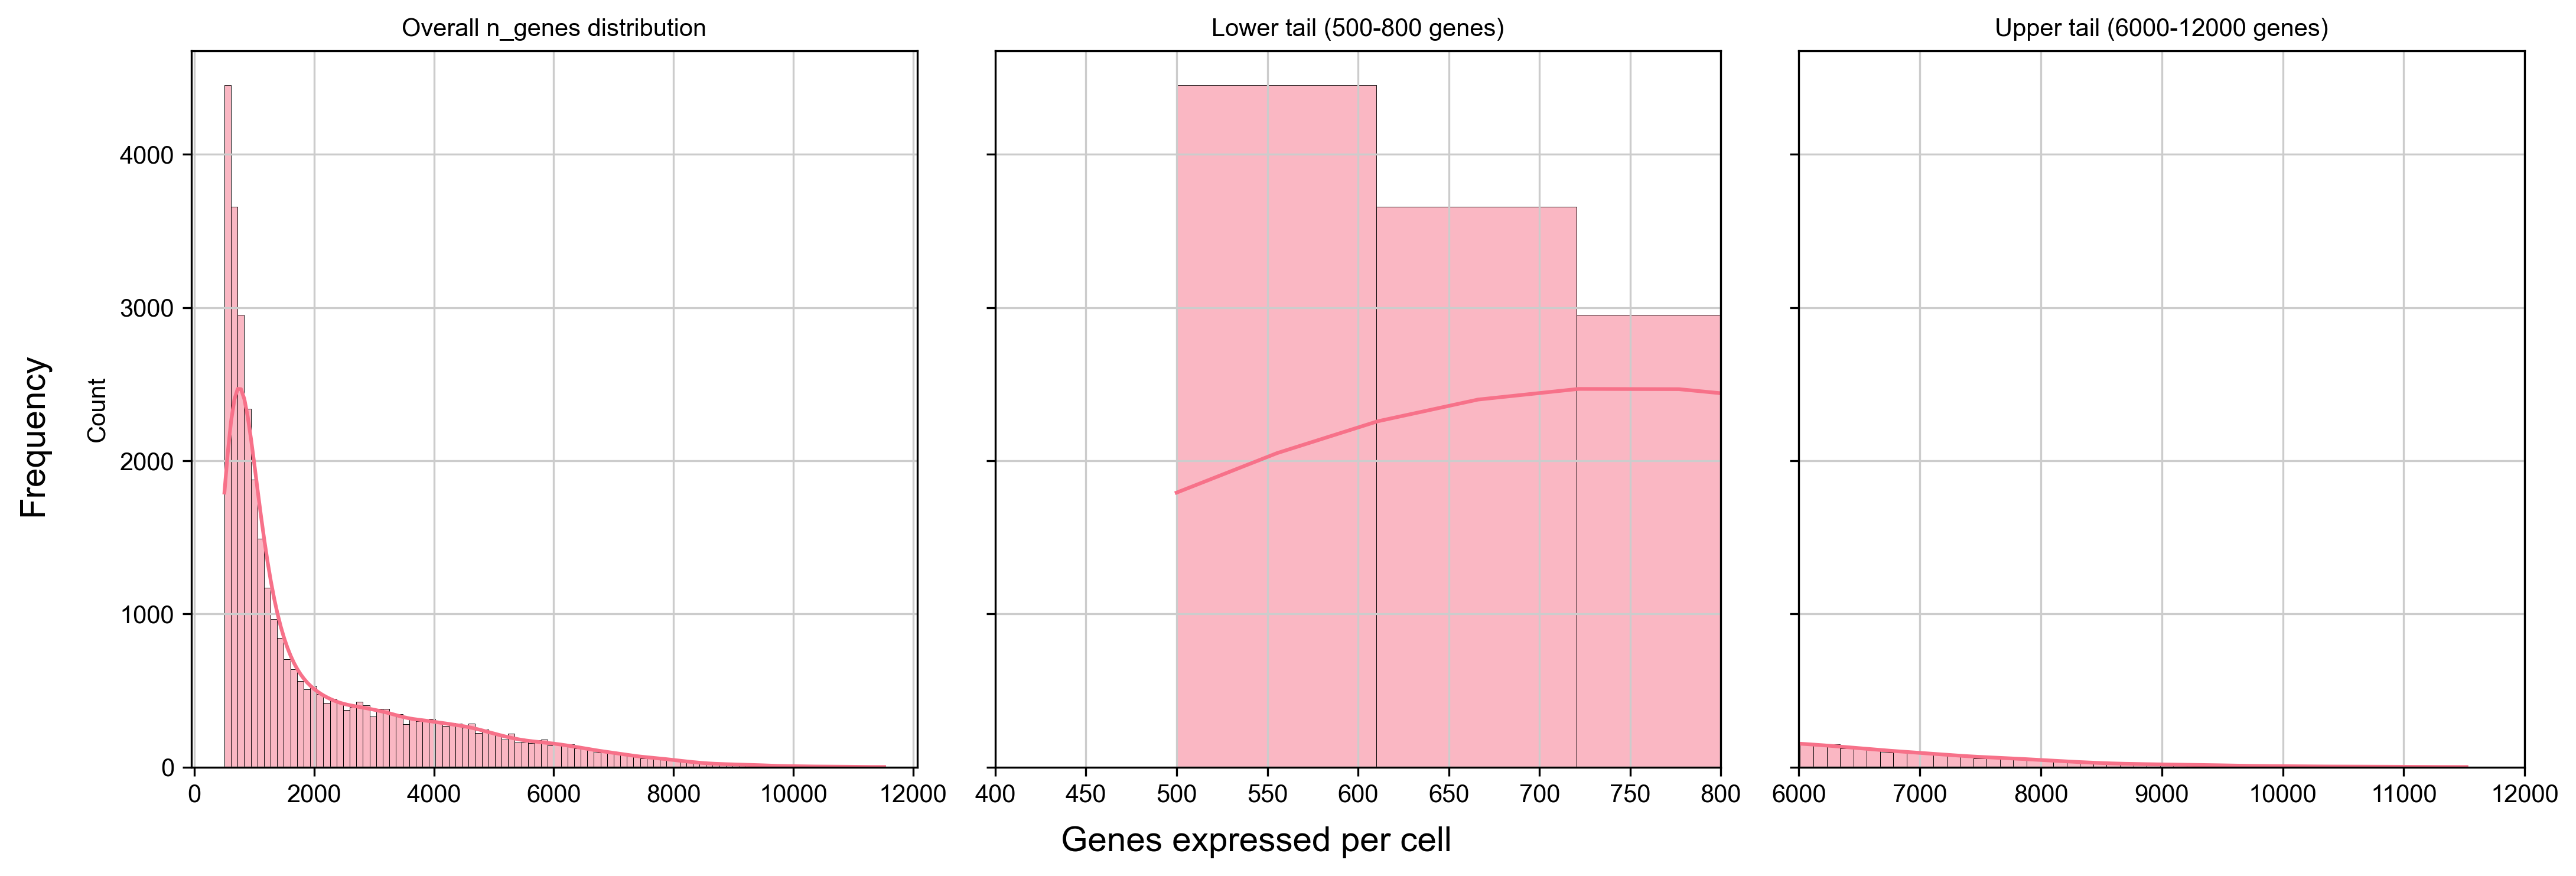

In [15]:
# Set the color palette
sns.set_palette("husl")

# Use the n_genes column from your AnnData object
x = adata.obs['n_genes']

# Define the number of bins for the histogram
nbins = 100

# Create subplots: overall distribution, lower tail, and upper tail
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=150, sharey=True)

# Overall n_genes distribution
sns.histplot(x, ax=ax1, bins=nbins, kde=True)
ax1.set_title('Overall n_genes distribution')

# Lower tail: limit x-axis from 500 to 800
sns.histplot(x, ax=ax2, bins=nbins, kde=True)
ax2.set_xlim(400, 800)
ax2.set_title('Lower tail (500-800 genes)')

# Upper tail: limit x-axis from 6000 to 12000
sns.histplot(x, ax=ax3, bins=nbins, kde=True)
ax3.set_xlim(6000, 12000)
ax3.set_title('Upper tail (6000-12000 genes)')

# Remove individual x-axis labels (use global x-label instead)
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('')

# Add a common y-axis label for Frequency
fig.text(0.04, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=14)

# Add a common x-axis label for Genes expressed per cell
fig.text(0.5, 0.04, 'Genes expressed per cell', ha='center', va='center', fontsize=14)

# Adjust layout to minimize overlap
fig.tight_layout(rect=[0.05, 0.05, 1, 1])

plt.show()

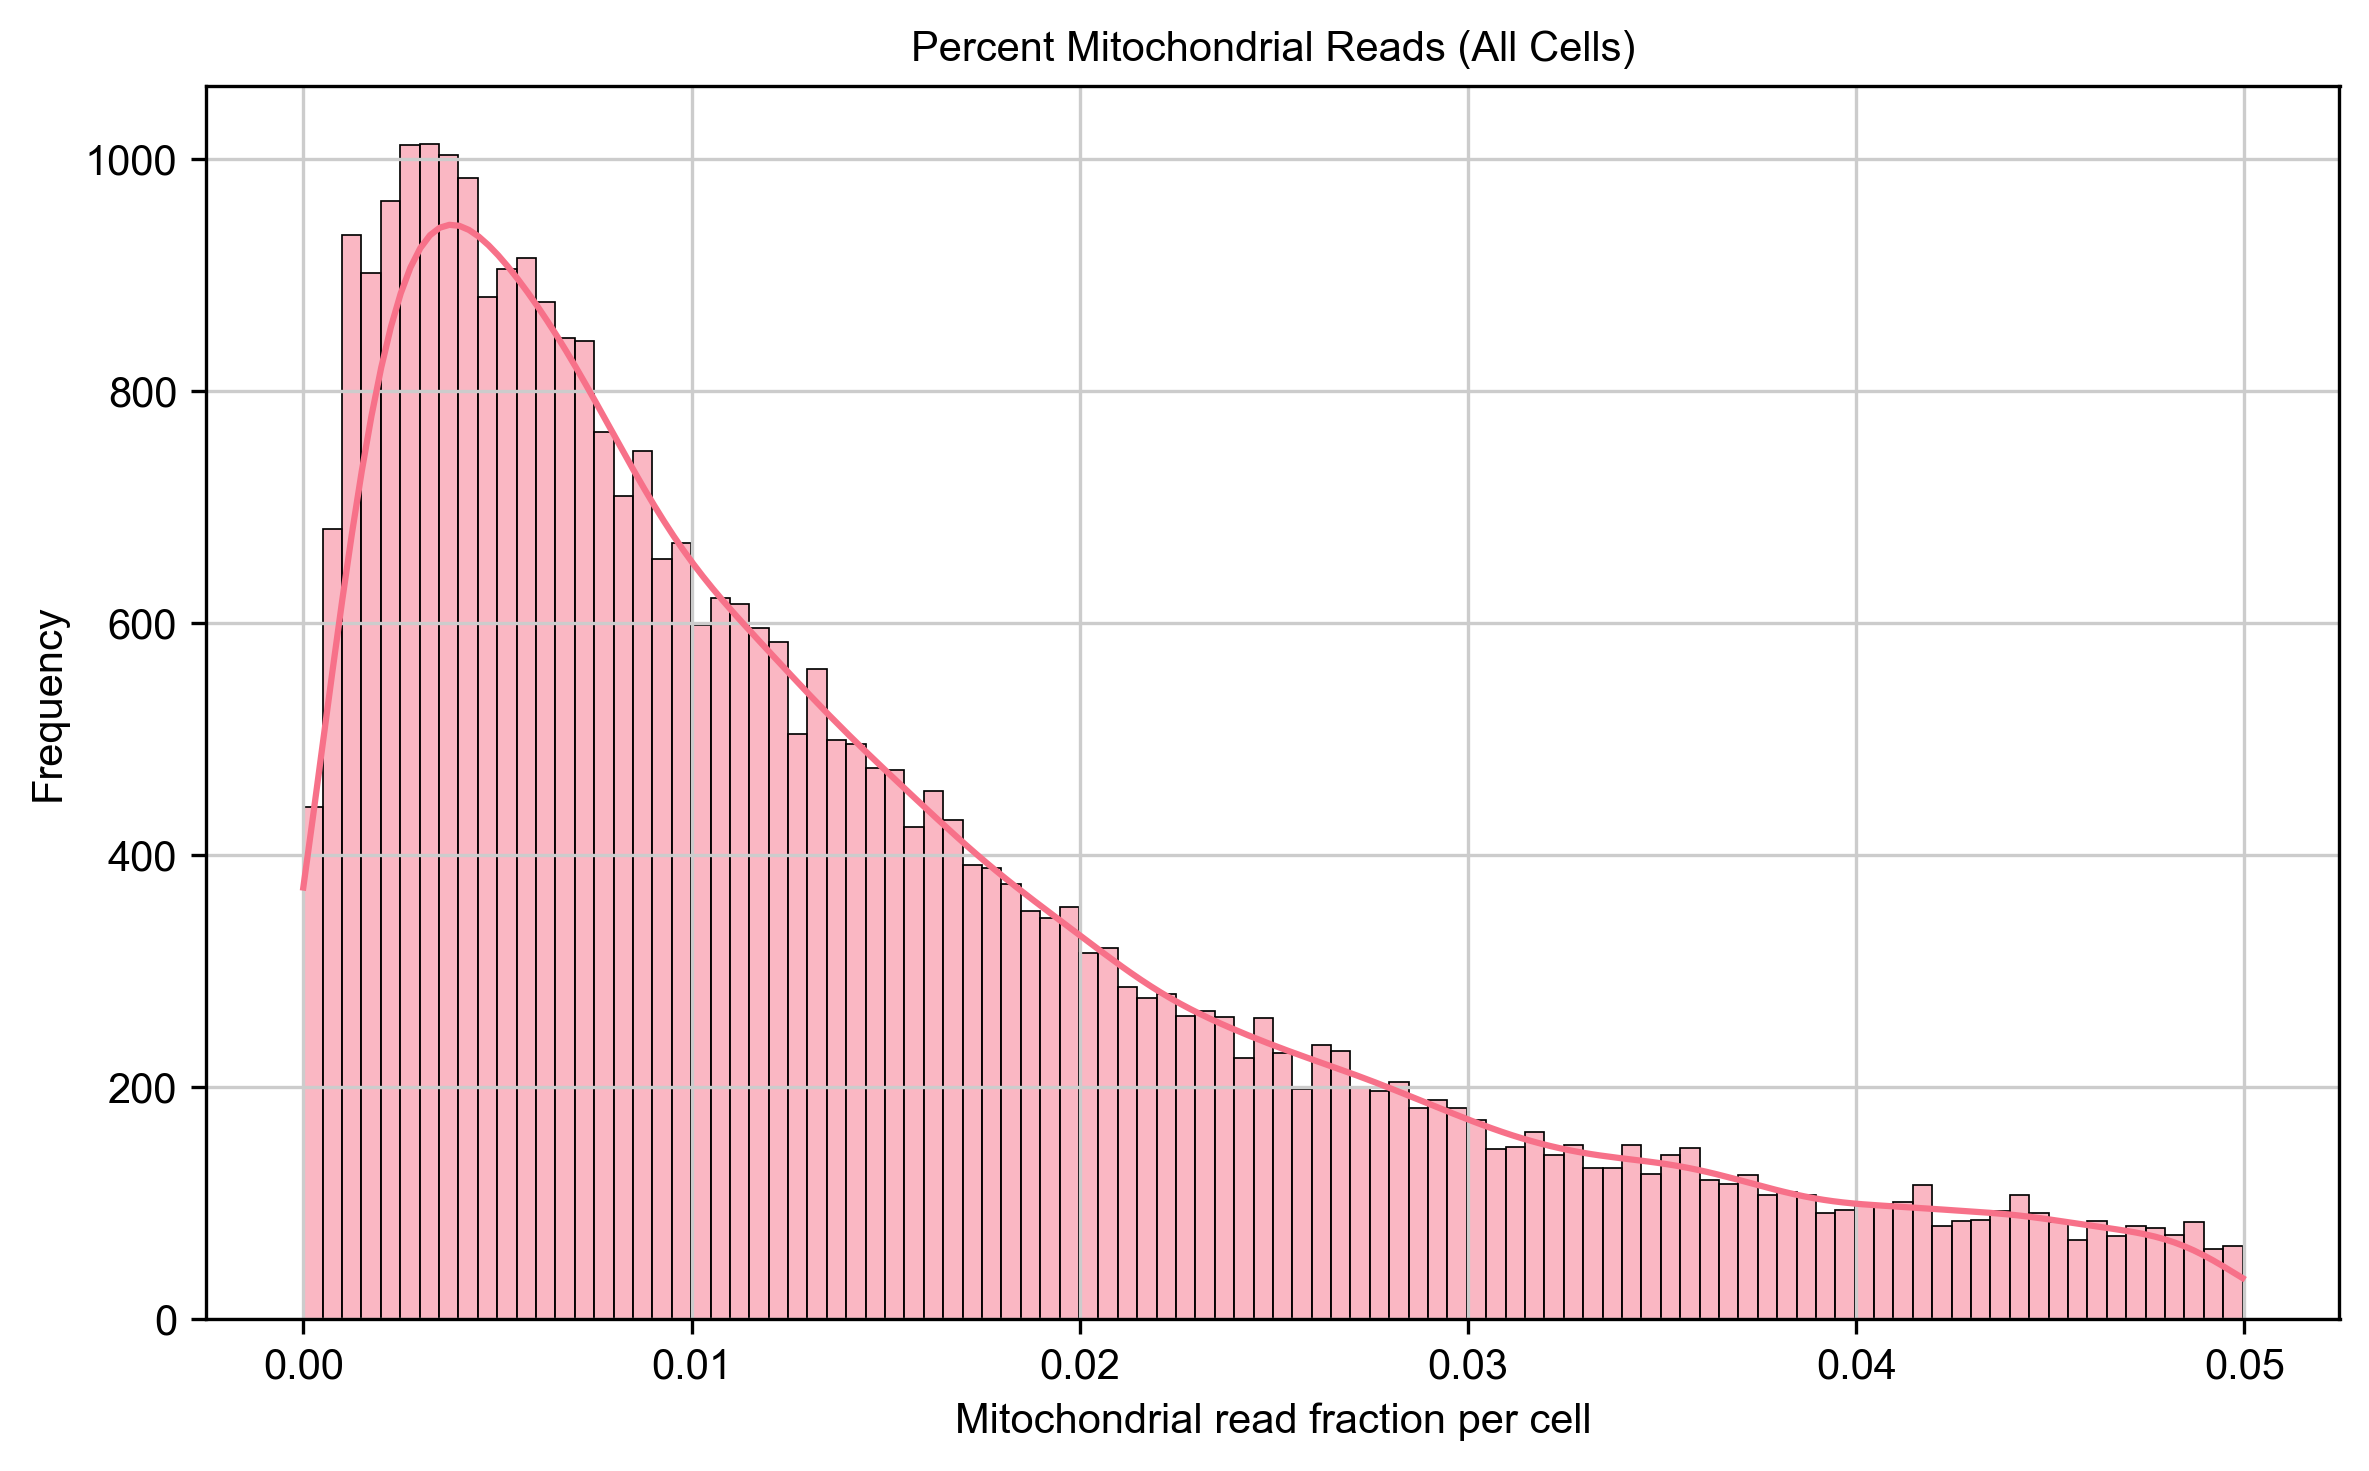

In [16]:
# Set the color palette (optional)
sns.set_palette("husl")

# Extract your data
x = adata.obs['percent_mito']
nbins = 100

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=150)
sns.histplot(x, ax=ax, bins=nbins, kde=True)
ax.set_title("Percent Mitochondrial Reads (All Cells)")
ax.set_xlabel("Mitochondrial read fraction per cell")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

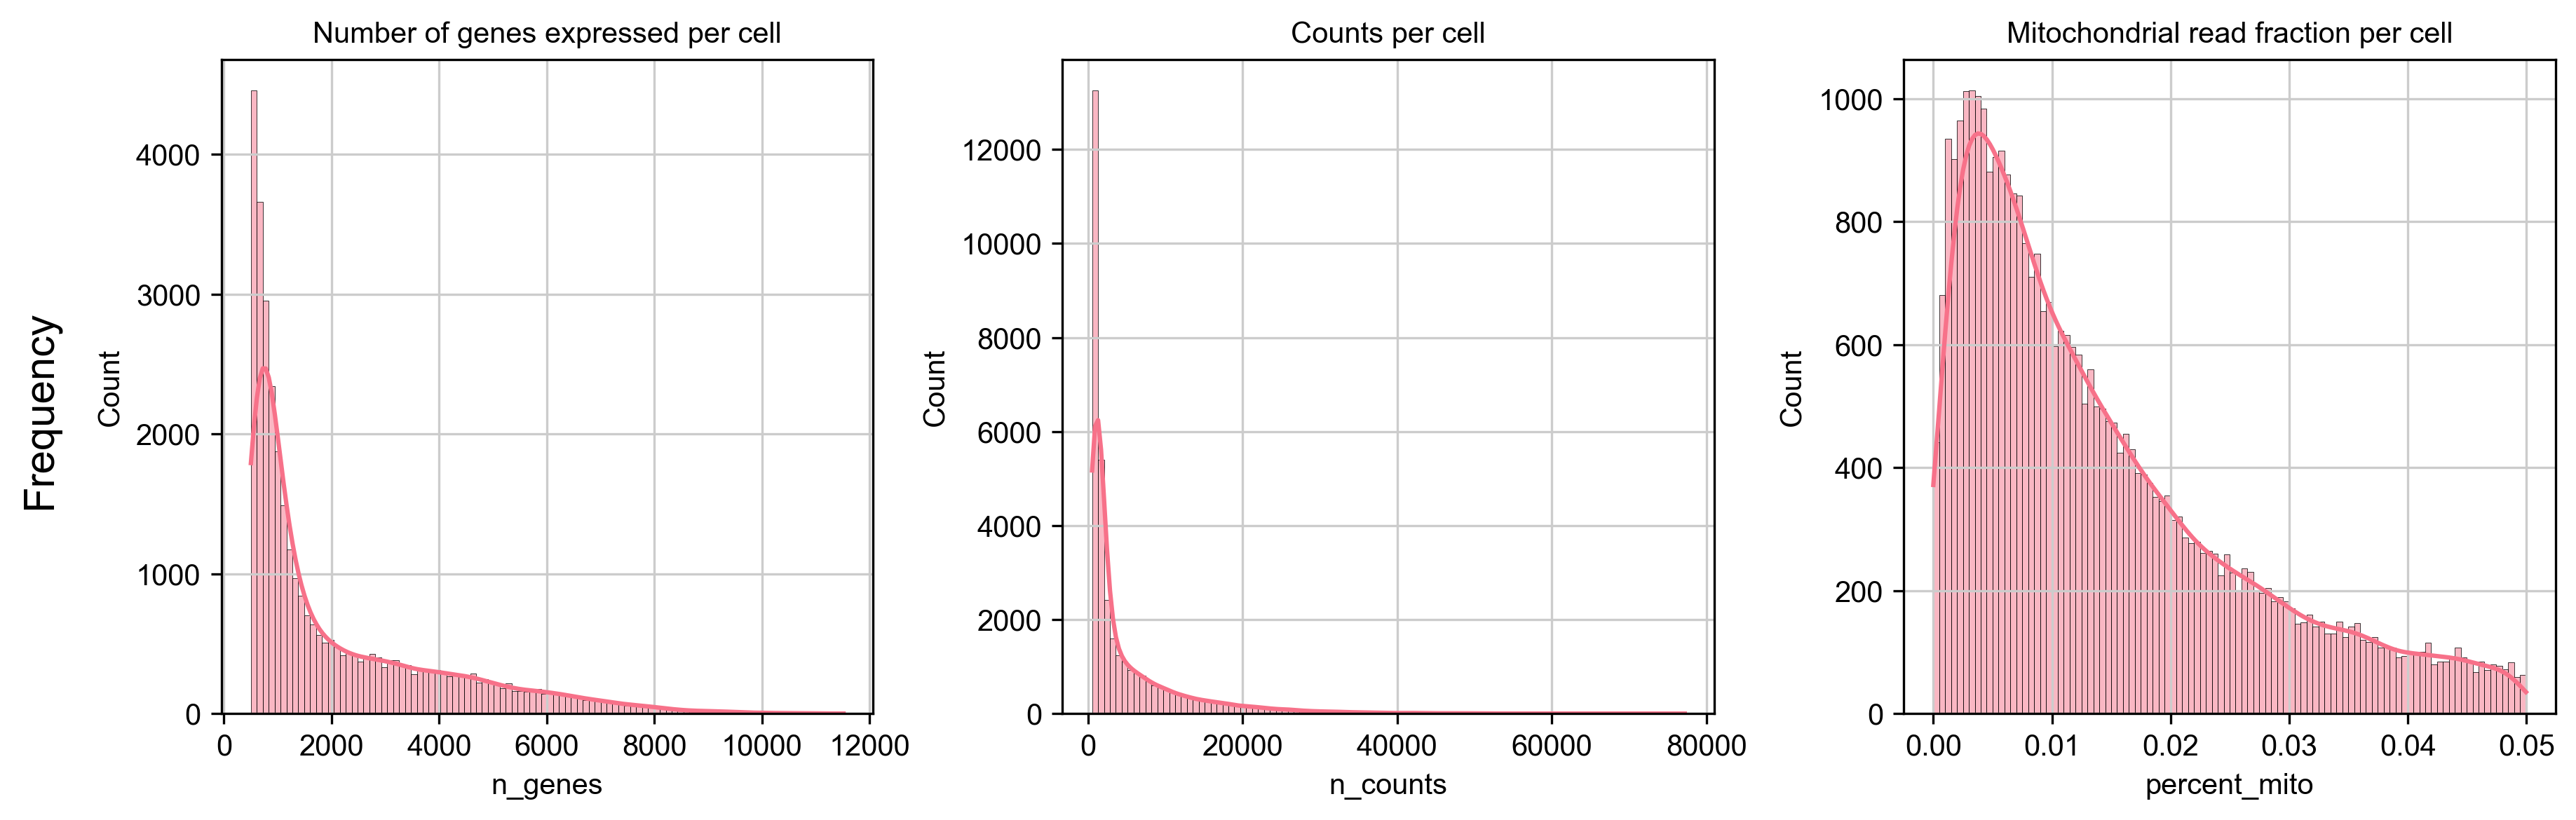

In [17]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

# Plot histograms with kernel density estimates
sns.histplot(adata.obs['n_genes'], ax=ax1, bins=100, kde=True)
sns.histplot(adata.obs['n_counts'], ax=ax2, bins=100, kde=True)
sns.histplot(adata.obs['percent_mito'], ax=ax3, bins=100, kde=True)

# Set titles
ax1.set_title('Number of genes expressed per cell')
ax2.set_title('Counts per cell')
ax3.set_title('Mitochondrial read fraction per cell')

# Set y-axis label
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

# Adjust layout
fig.tight_layout()

# Save the figure
fig.savefig('Results/Velmeshev/ASD/filtering_panel_prefilter_ACC.pdf', dpi=600, bbox_inches='tight')

/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:921: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g: sns.axisgrid.FacetGrid = sns.catplot(


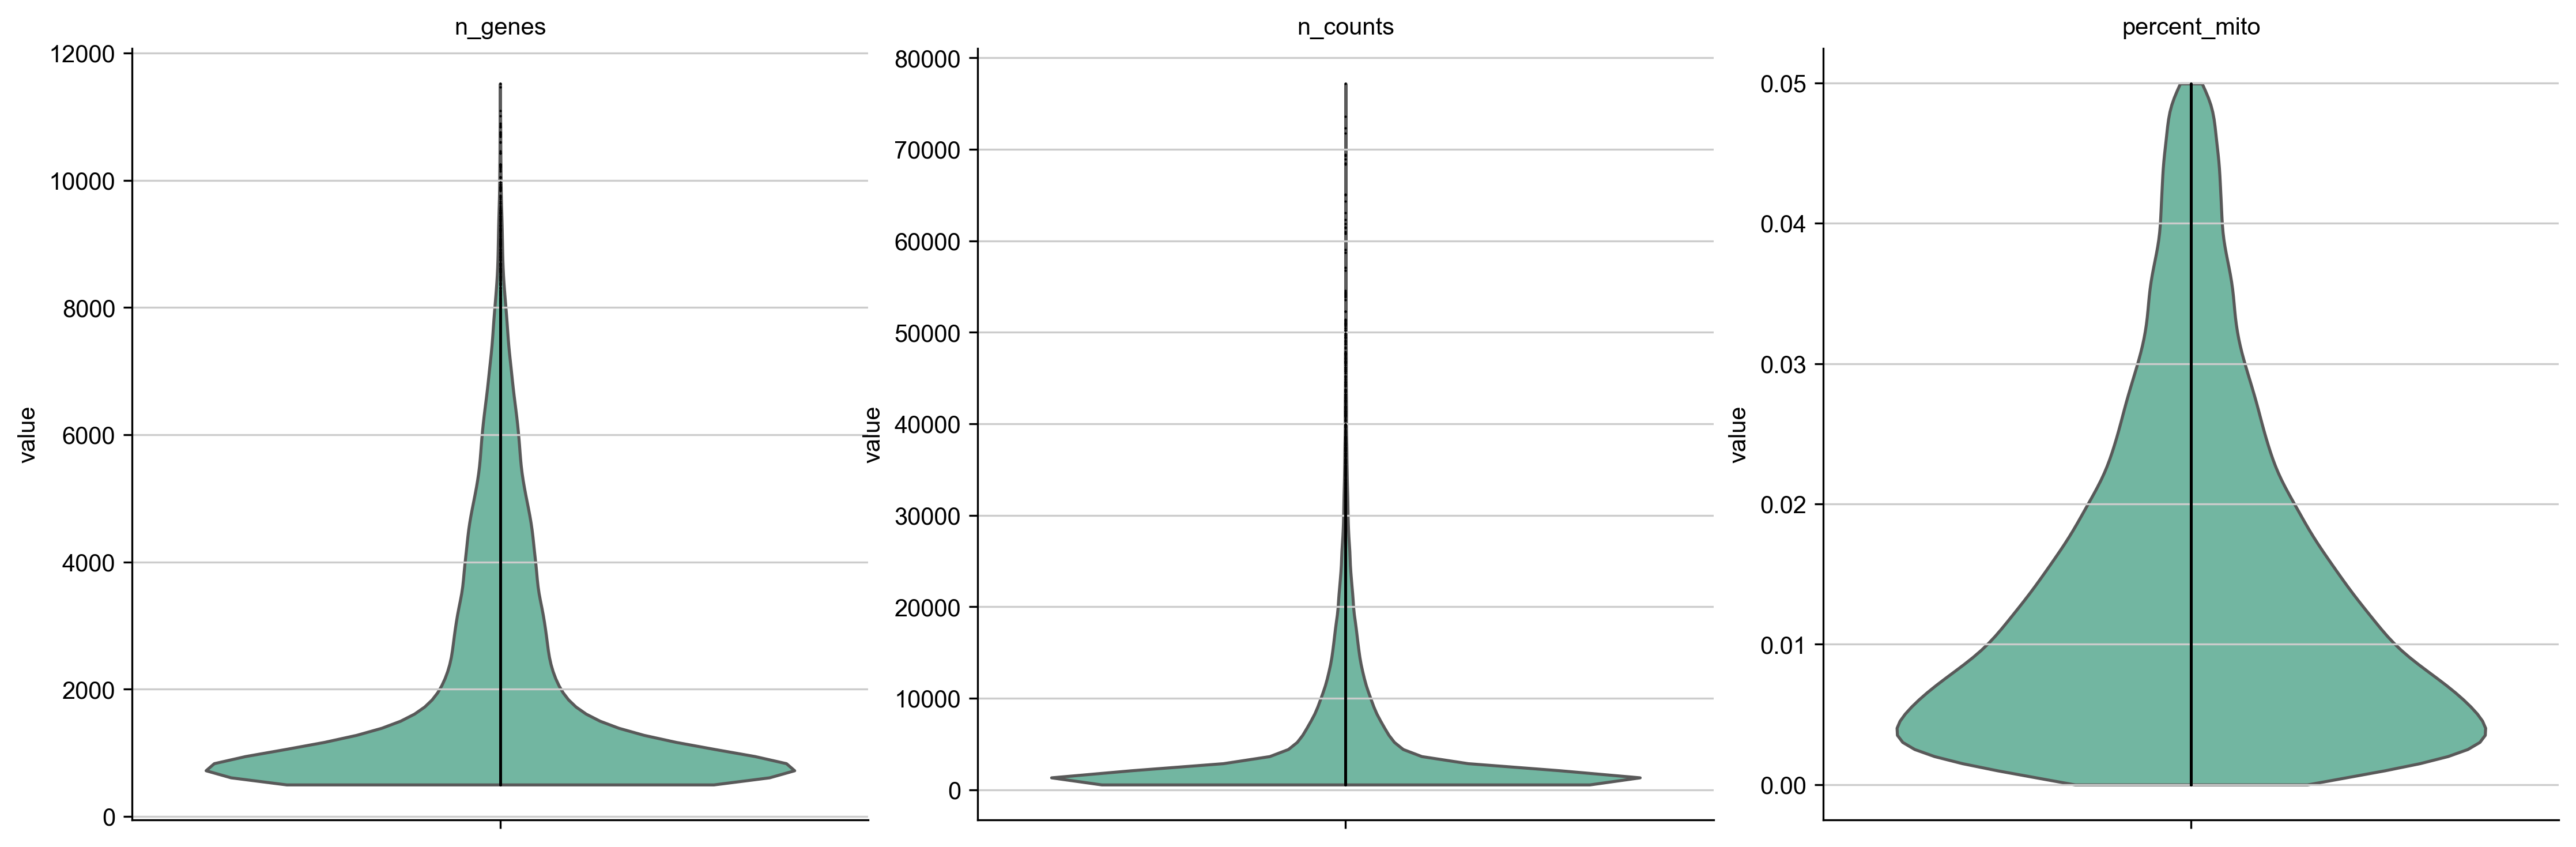

In [18]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0, multi_panel=True, palette="Set2")

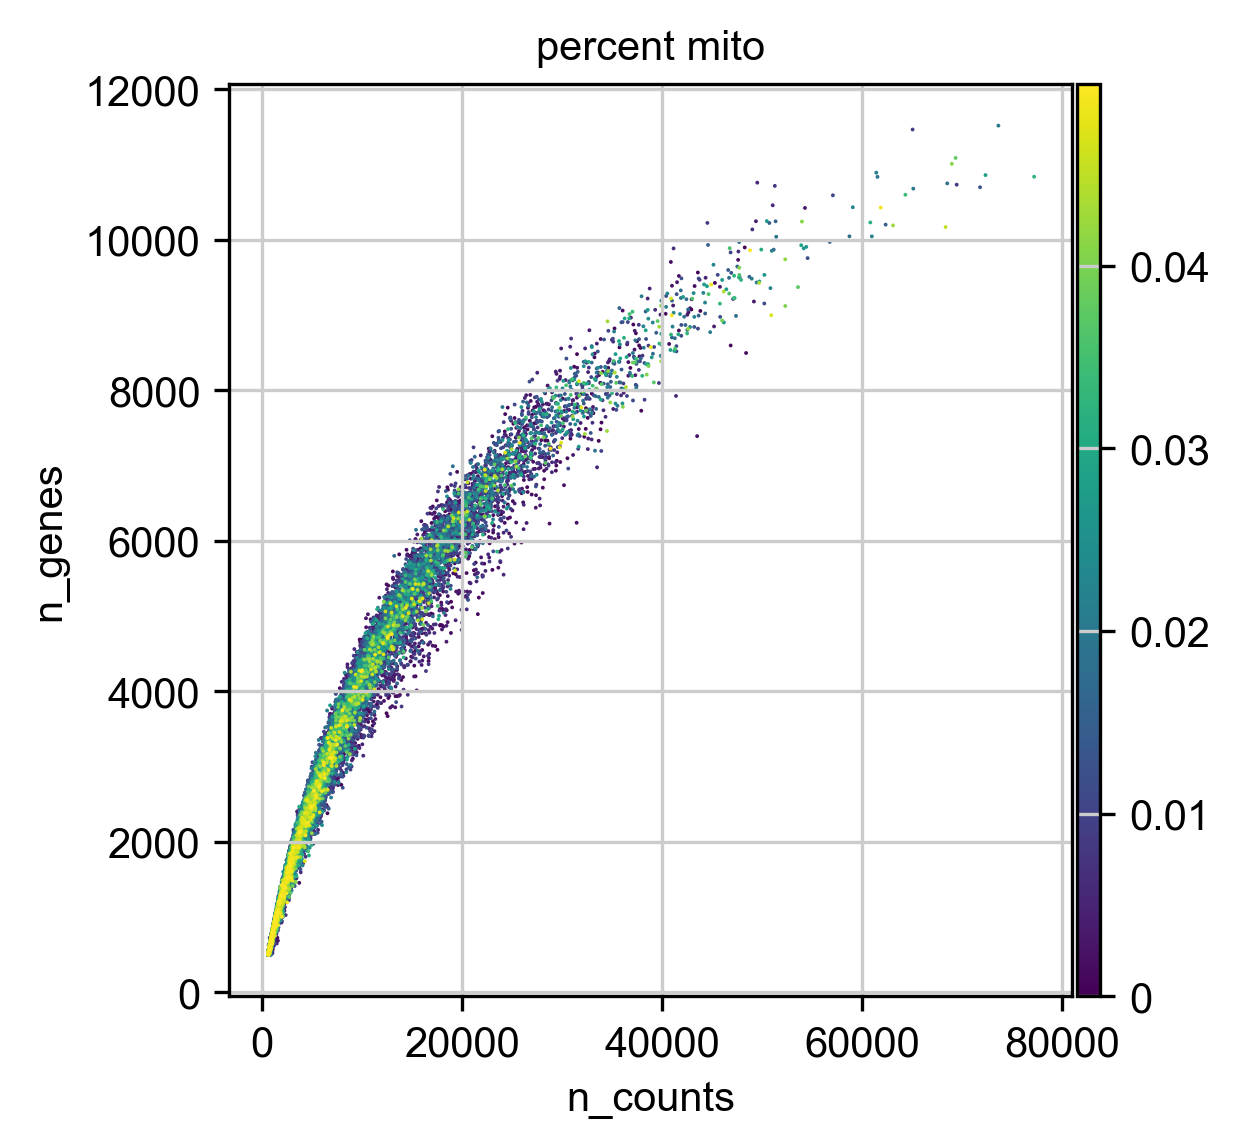

In [19]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [20]:
sc.pp.filter_cells(adata, min_genes=500 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 30472 genes that are detected in less than 3 cells


In [21]:
adata = adata[adata.obs['n_genes'] < 8000, :]

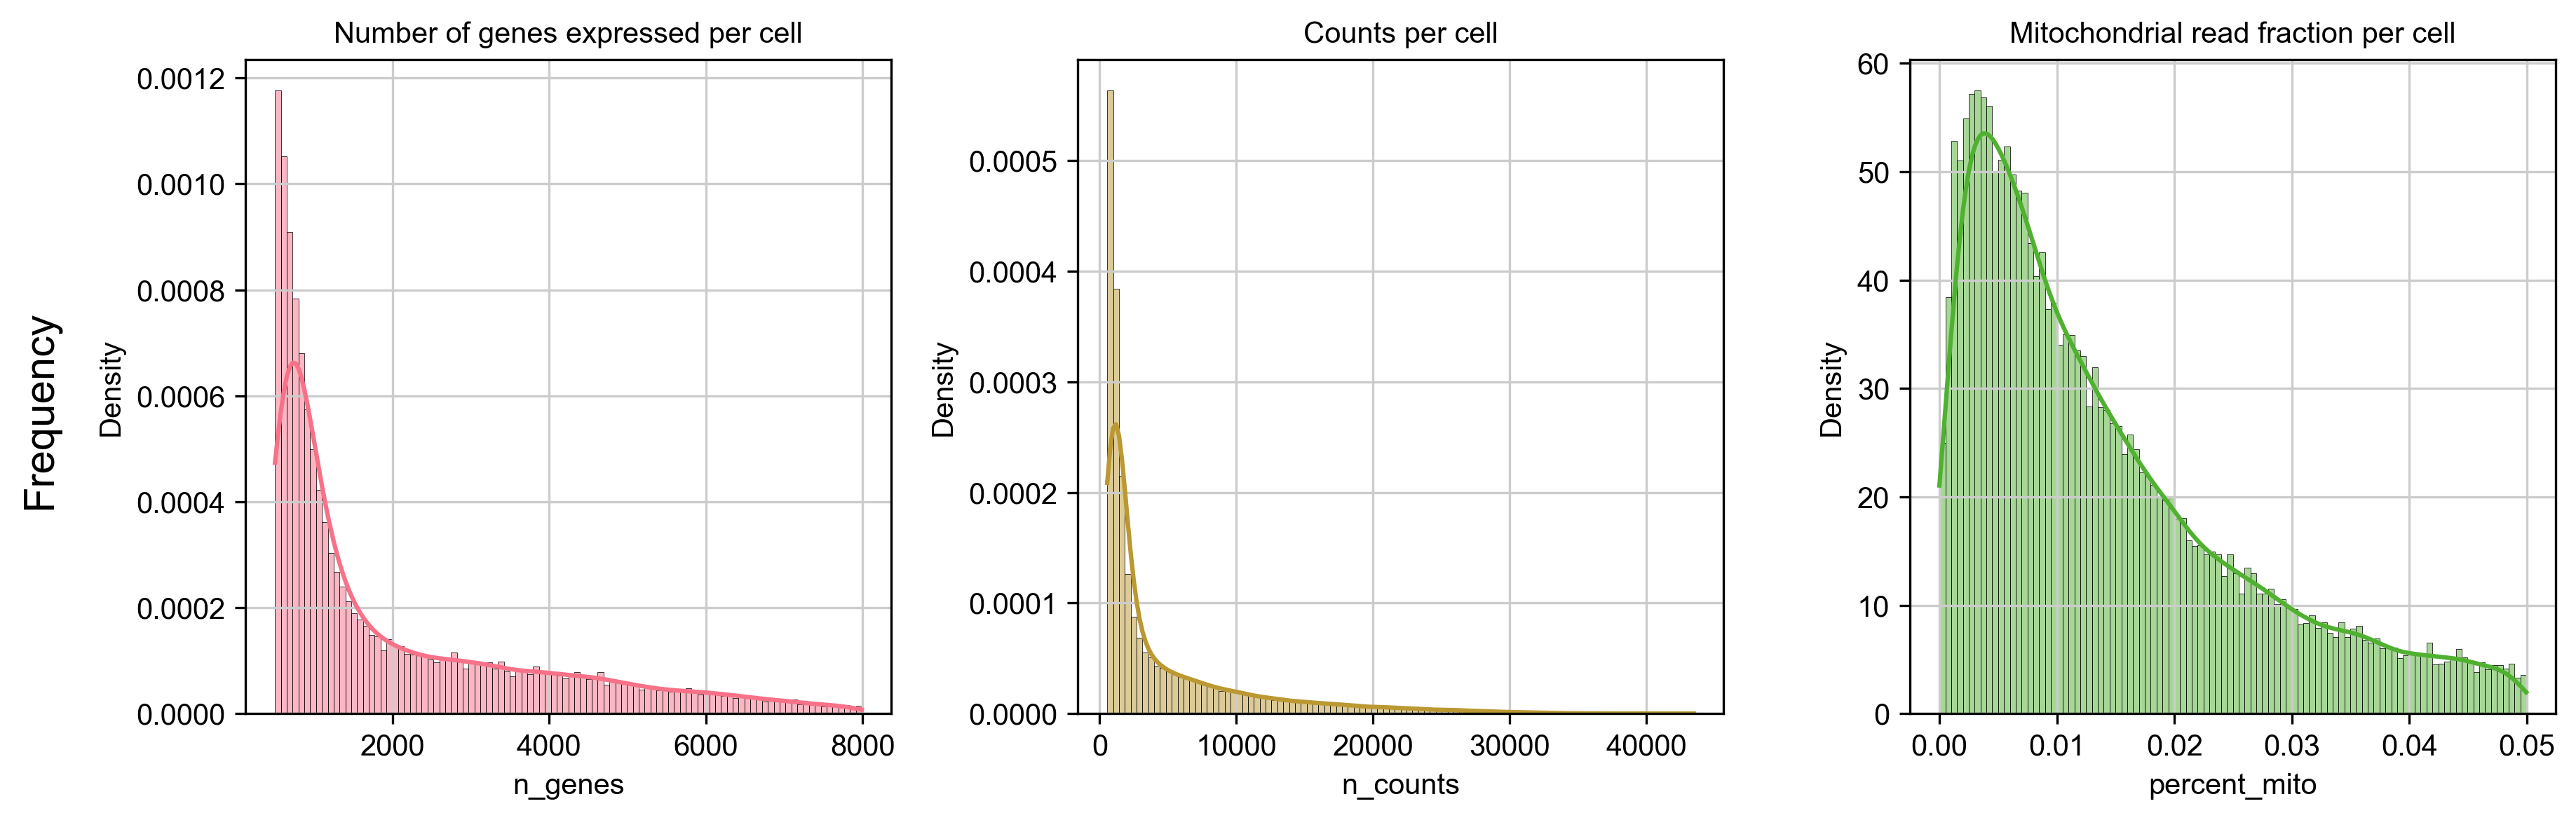

In [22]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

# Plot histograms with kernel density estimates
sns.histplot(adata.obs['n_genes'], ax=ax1, bins=100, kde=True, color=sns.color_palette("husl")[0], stat="density")
sns.histplot(adata.obs['n_counts'], ax=ax2, bins=100, kde=True, color=sns.color_palette("husl")[1], stat="density")
sns.histplot(adata.obs['percent_mito'], ax=ax3, bins=100, kde=True, color=sns.color_palette("husl")[2], stat="density")

# Set titles
ax1.set_title('Number of genes expressed per cell')
ax2.set_title('Counts per cell')
ax3.set_title('Mitochondrial read fraction per cell')

# Set y-axis label
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

# Adjust layout
fig.tight_layout()

# Save the figure
fig.savefig('Results/Velmeshev/ASD/filtering_panel_postfilter_ACC.pdf', dpi=600, bbox_inches='tight')

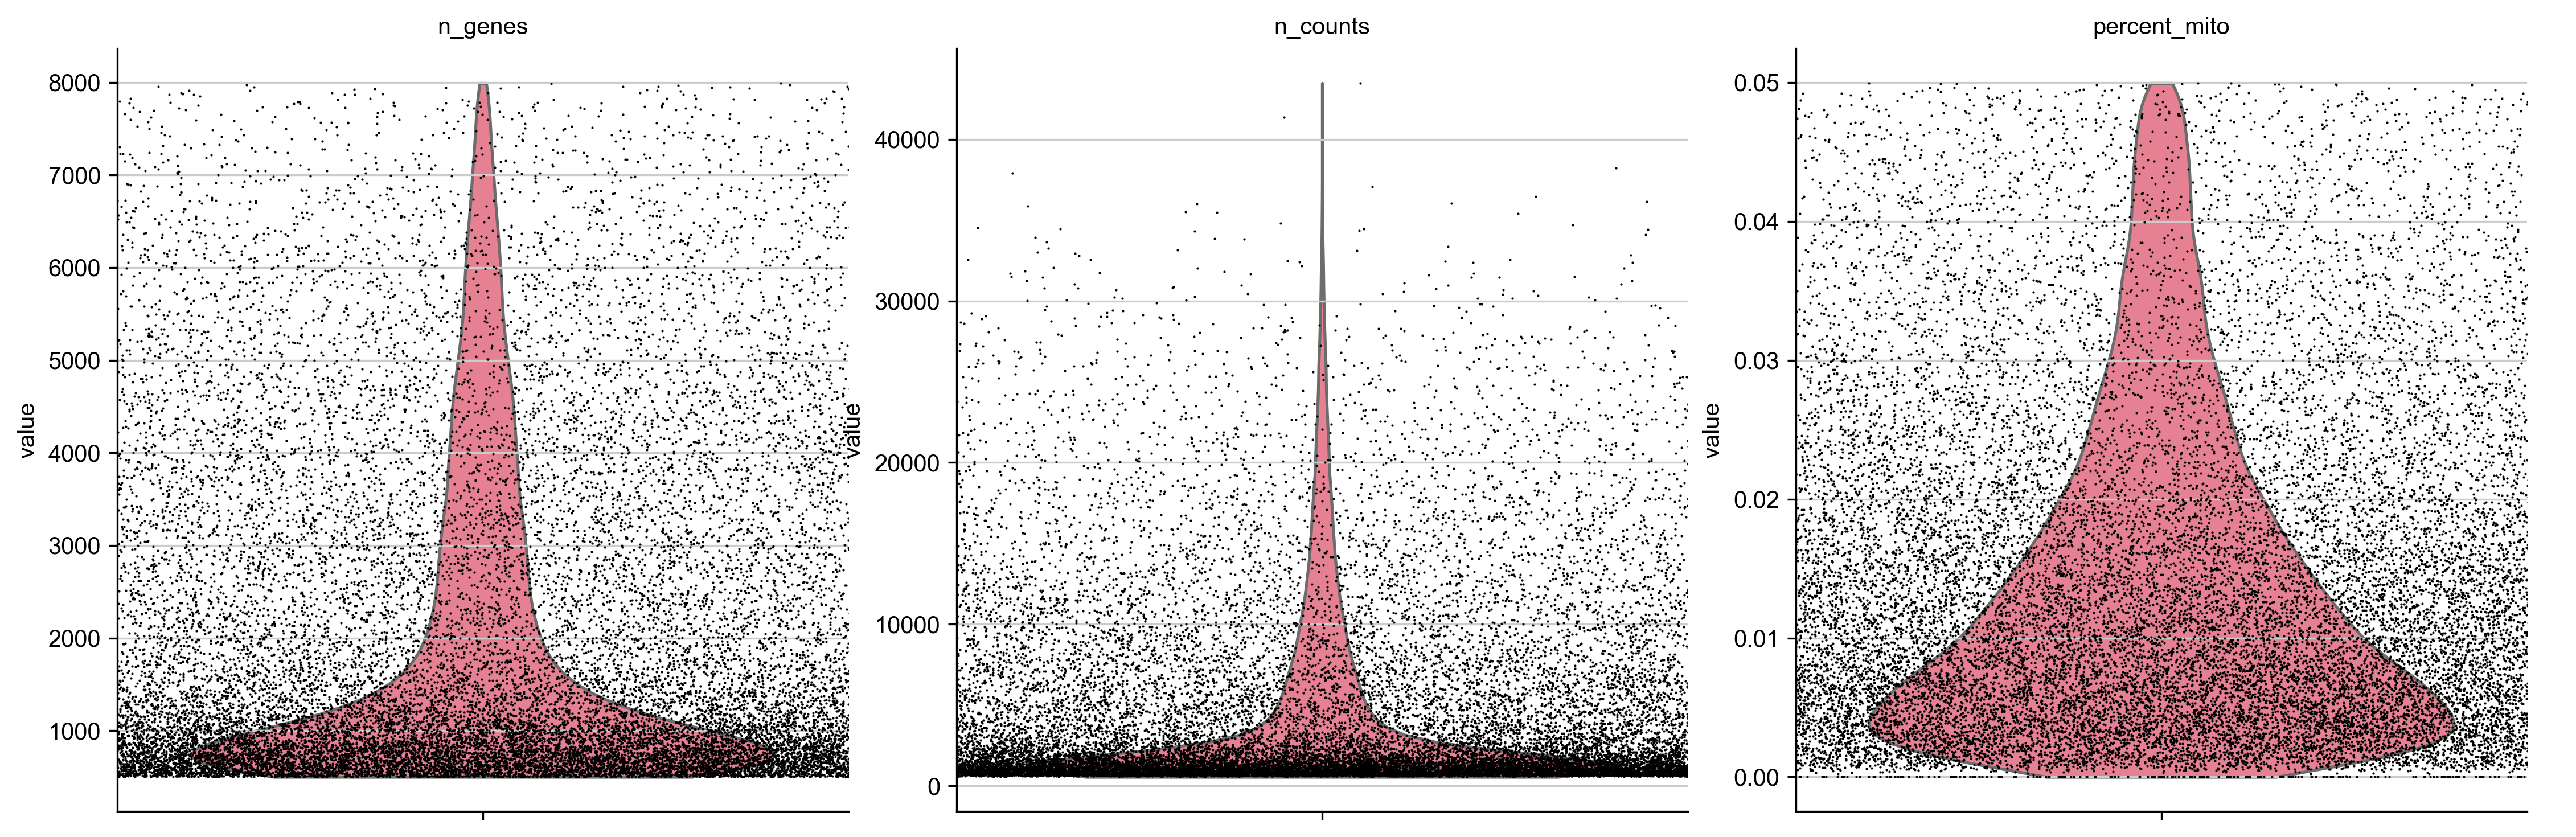

In [23]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.8, multi_panel=True )

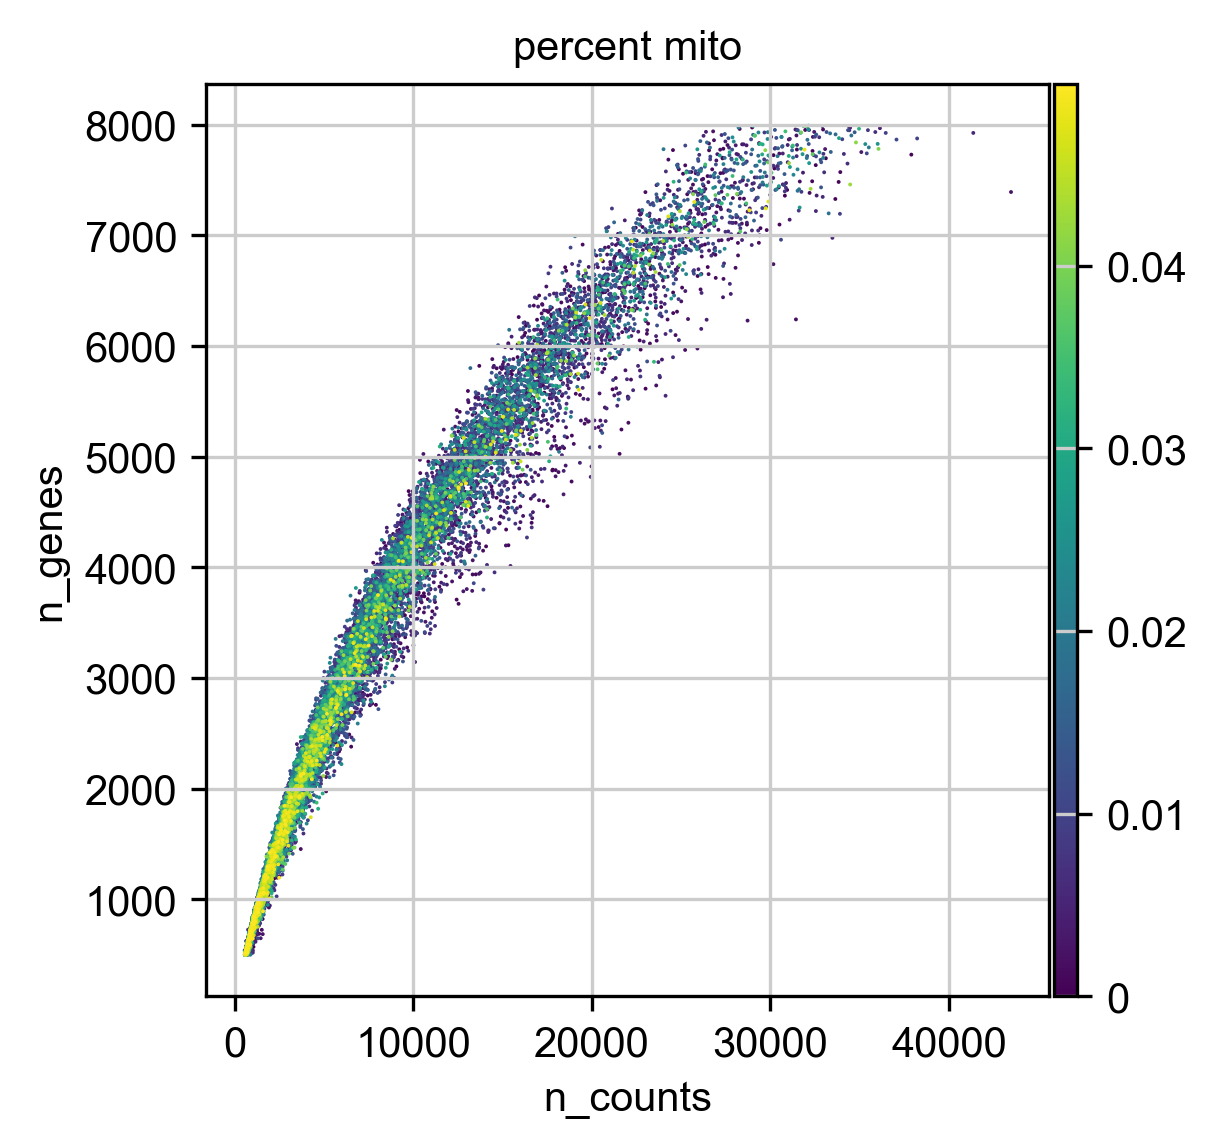

In [24]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [25]:
adata.write( f_anndata_path )

In [26]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

normalizing by total count per cell


/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_74937/3186822170.py:5: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:589: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


    finished (0:00:01): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


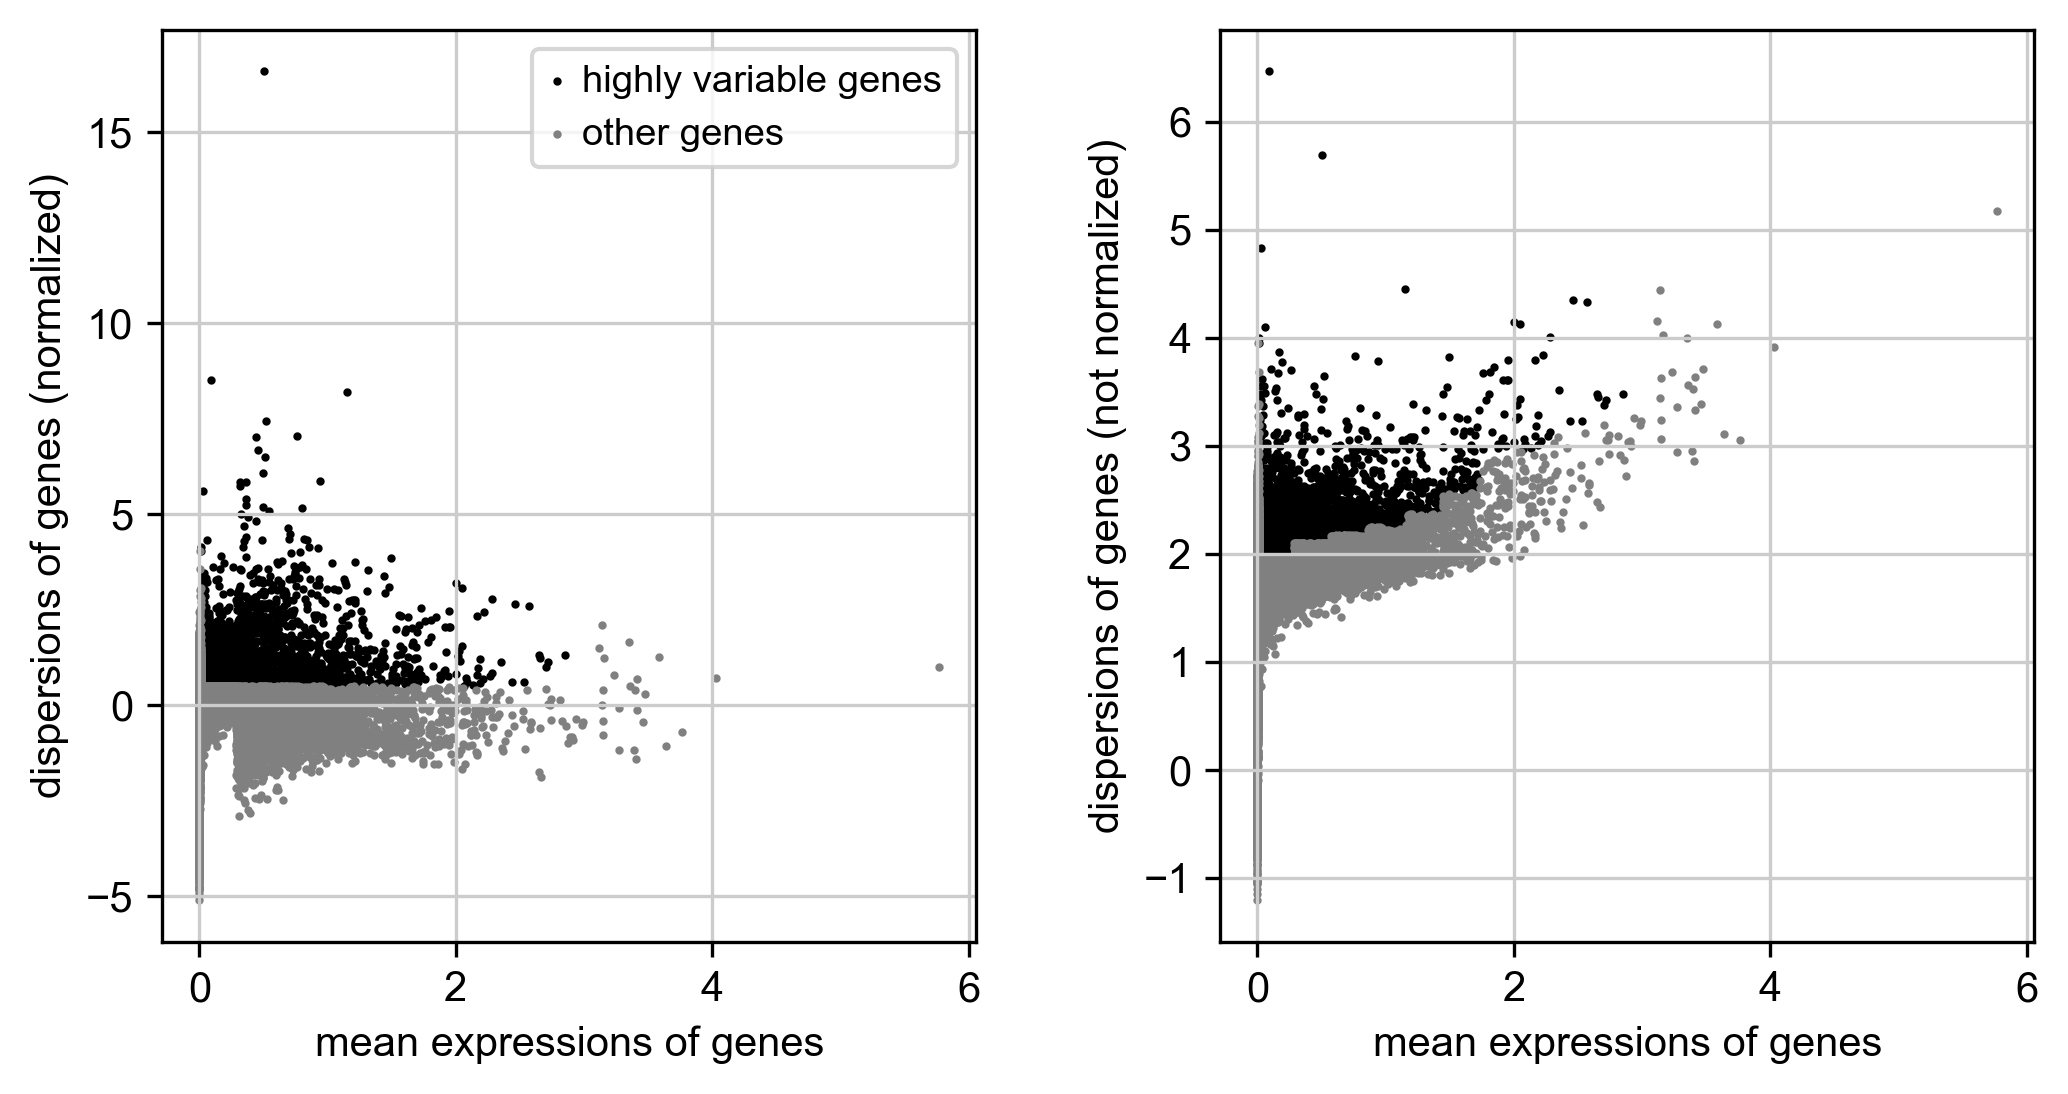

regressing out ['n_counts', 'percent_mito']


/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:710: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:00:01)


In [27]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# update the anndata file:
adata.write( f_anndata_path )

computing PCA
    with n_comps=50
    finished (0:00:09)


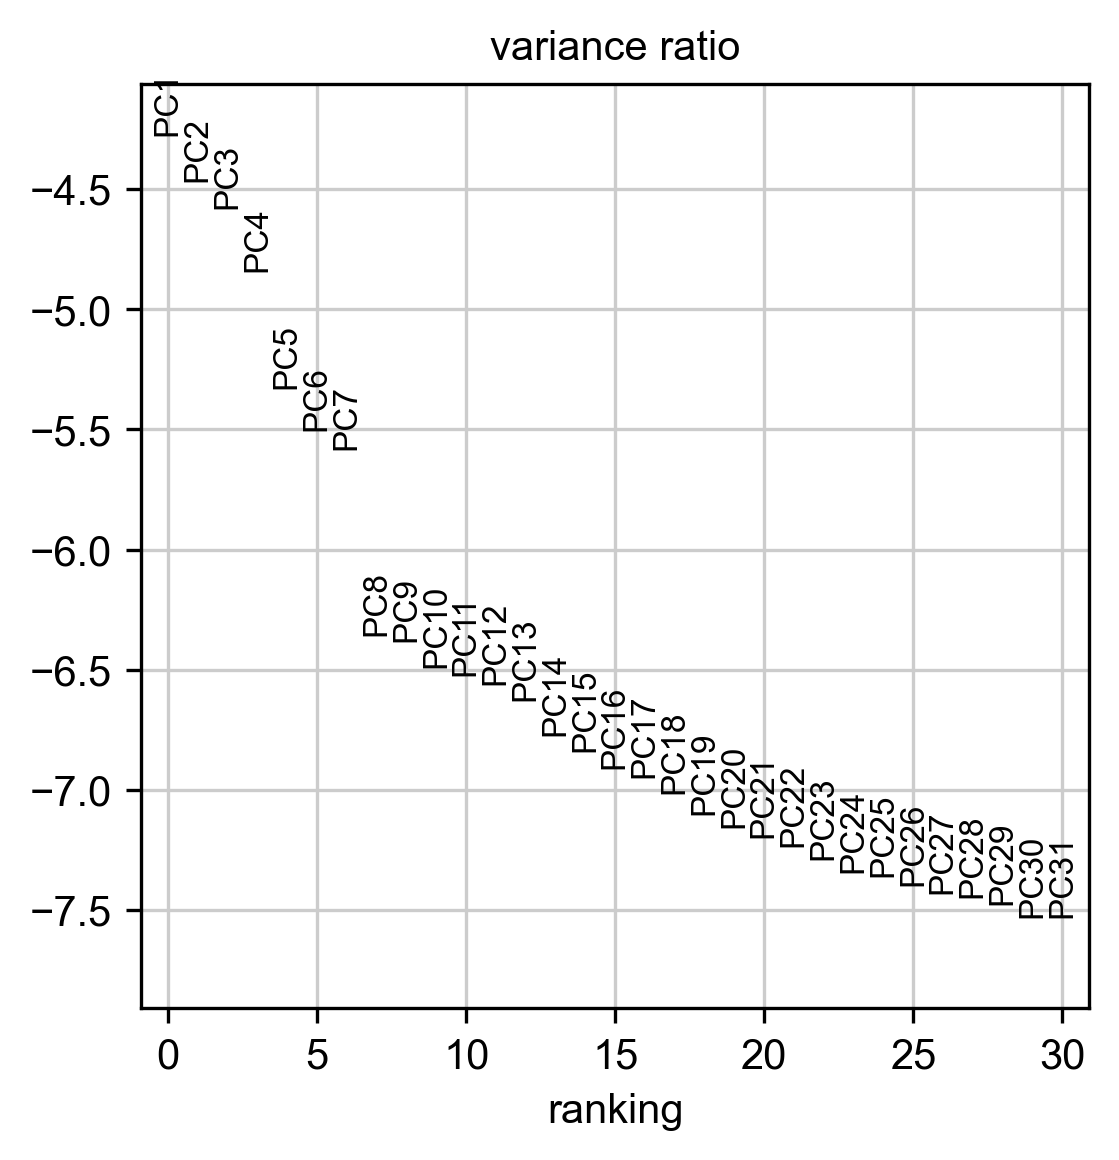

In [28]:
# adata = sc.read_h5ad( f_anndata_path )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

In [29]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:04)


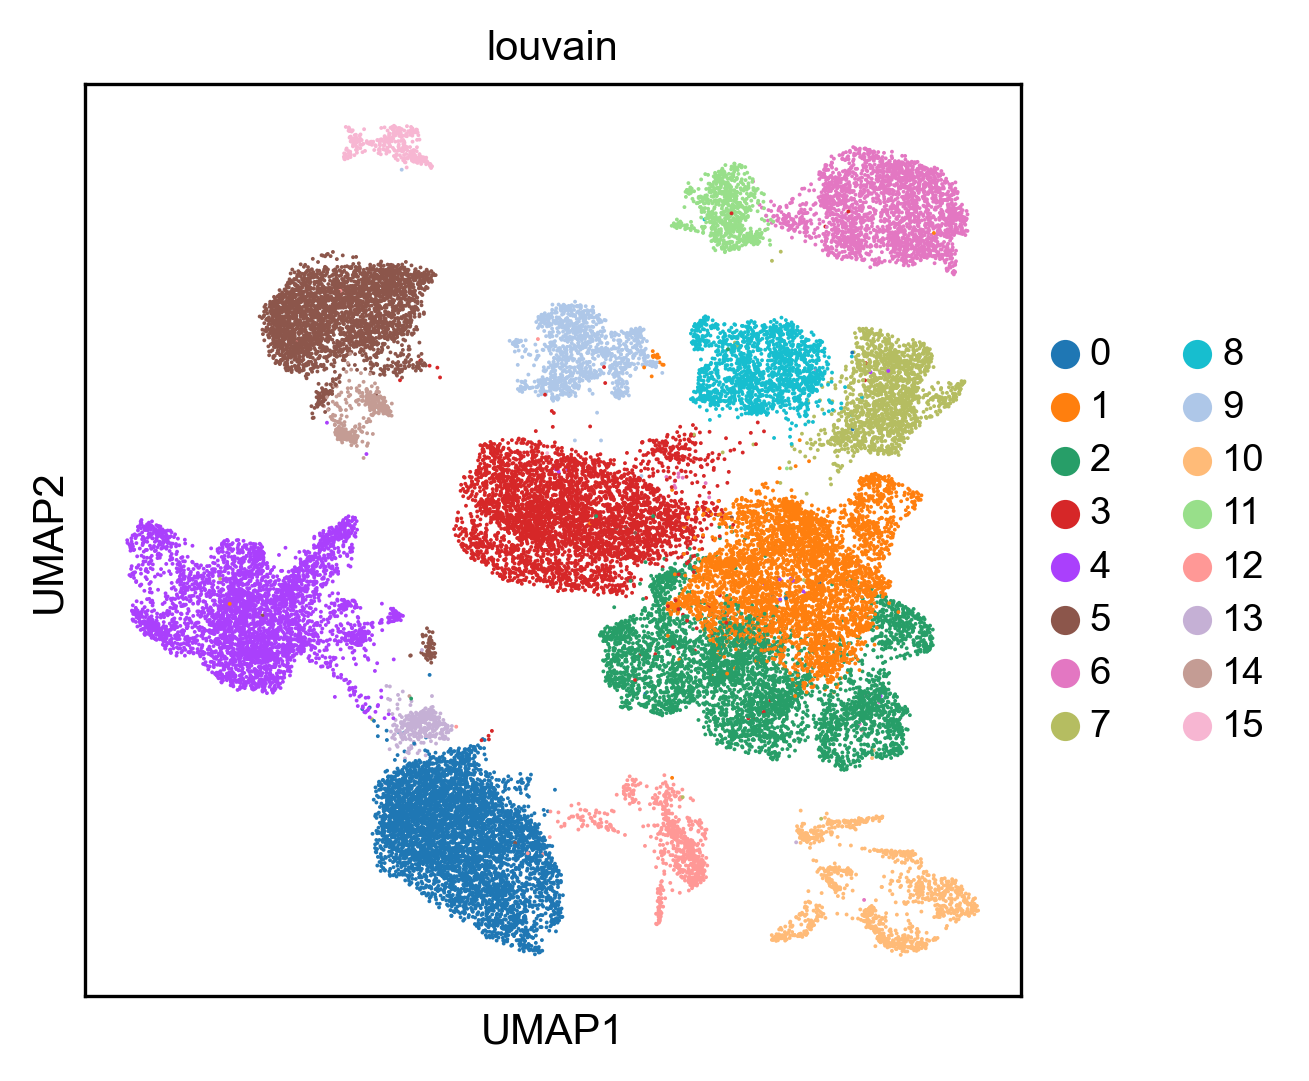

In [30]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)

sc.pl.umap(adata, color=['louvain'] )

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:04)


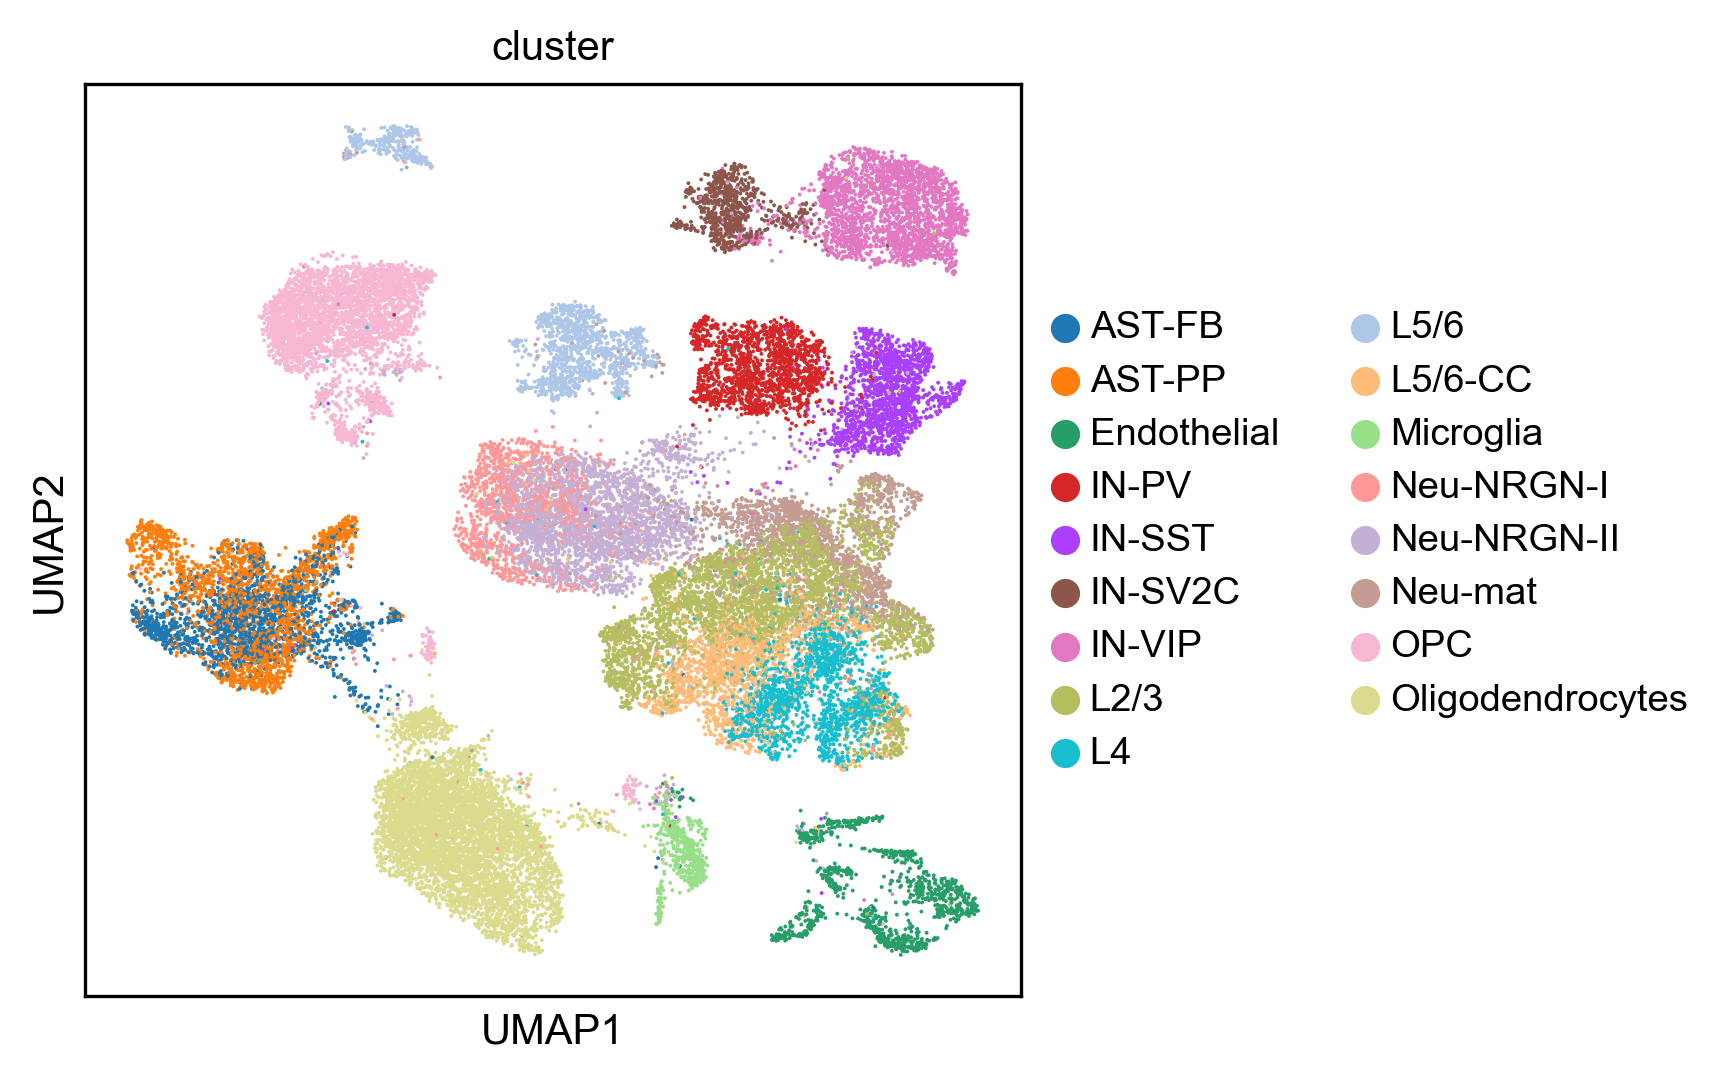

In [32]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)

sc.pl.umap(adata, color=['cluster'] )

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


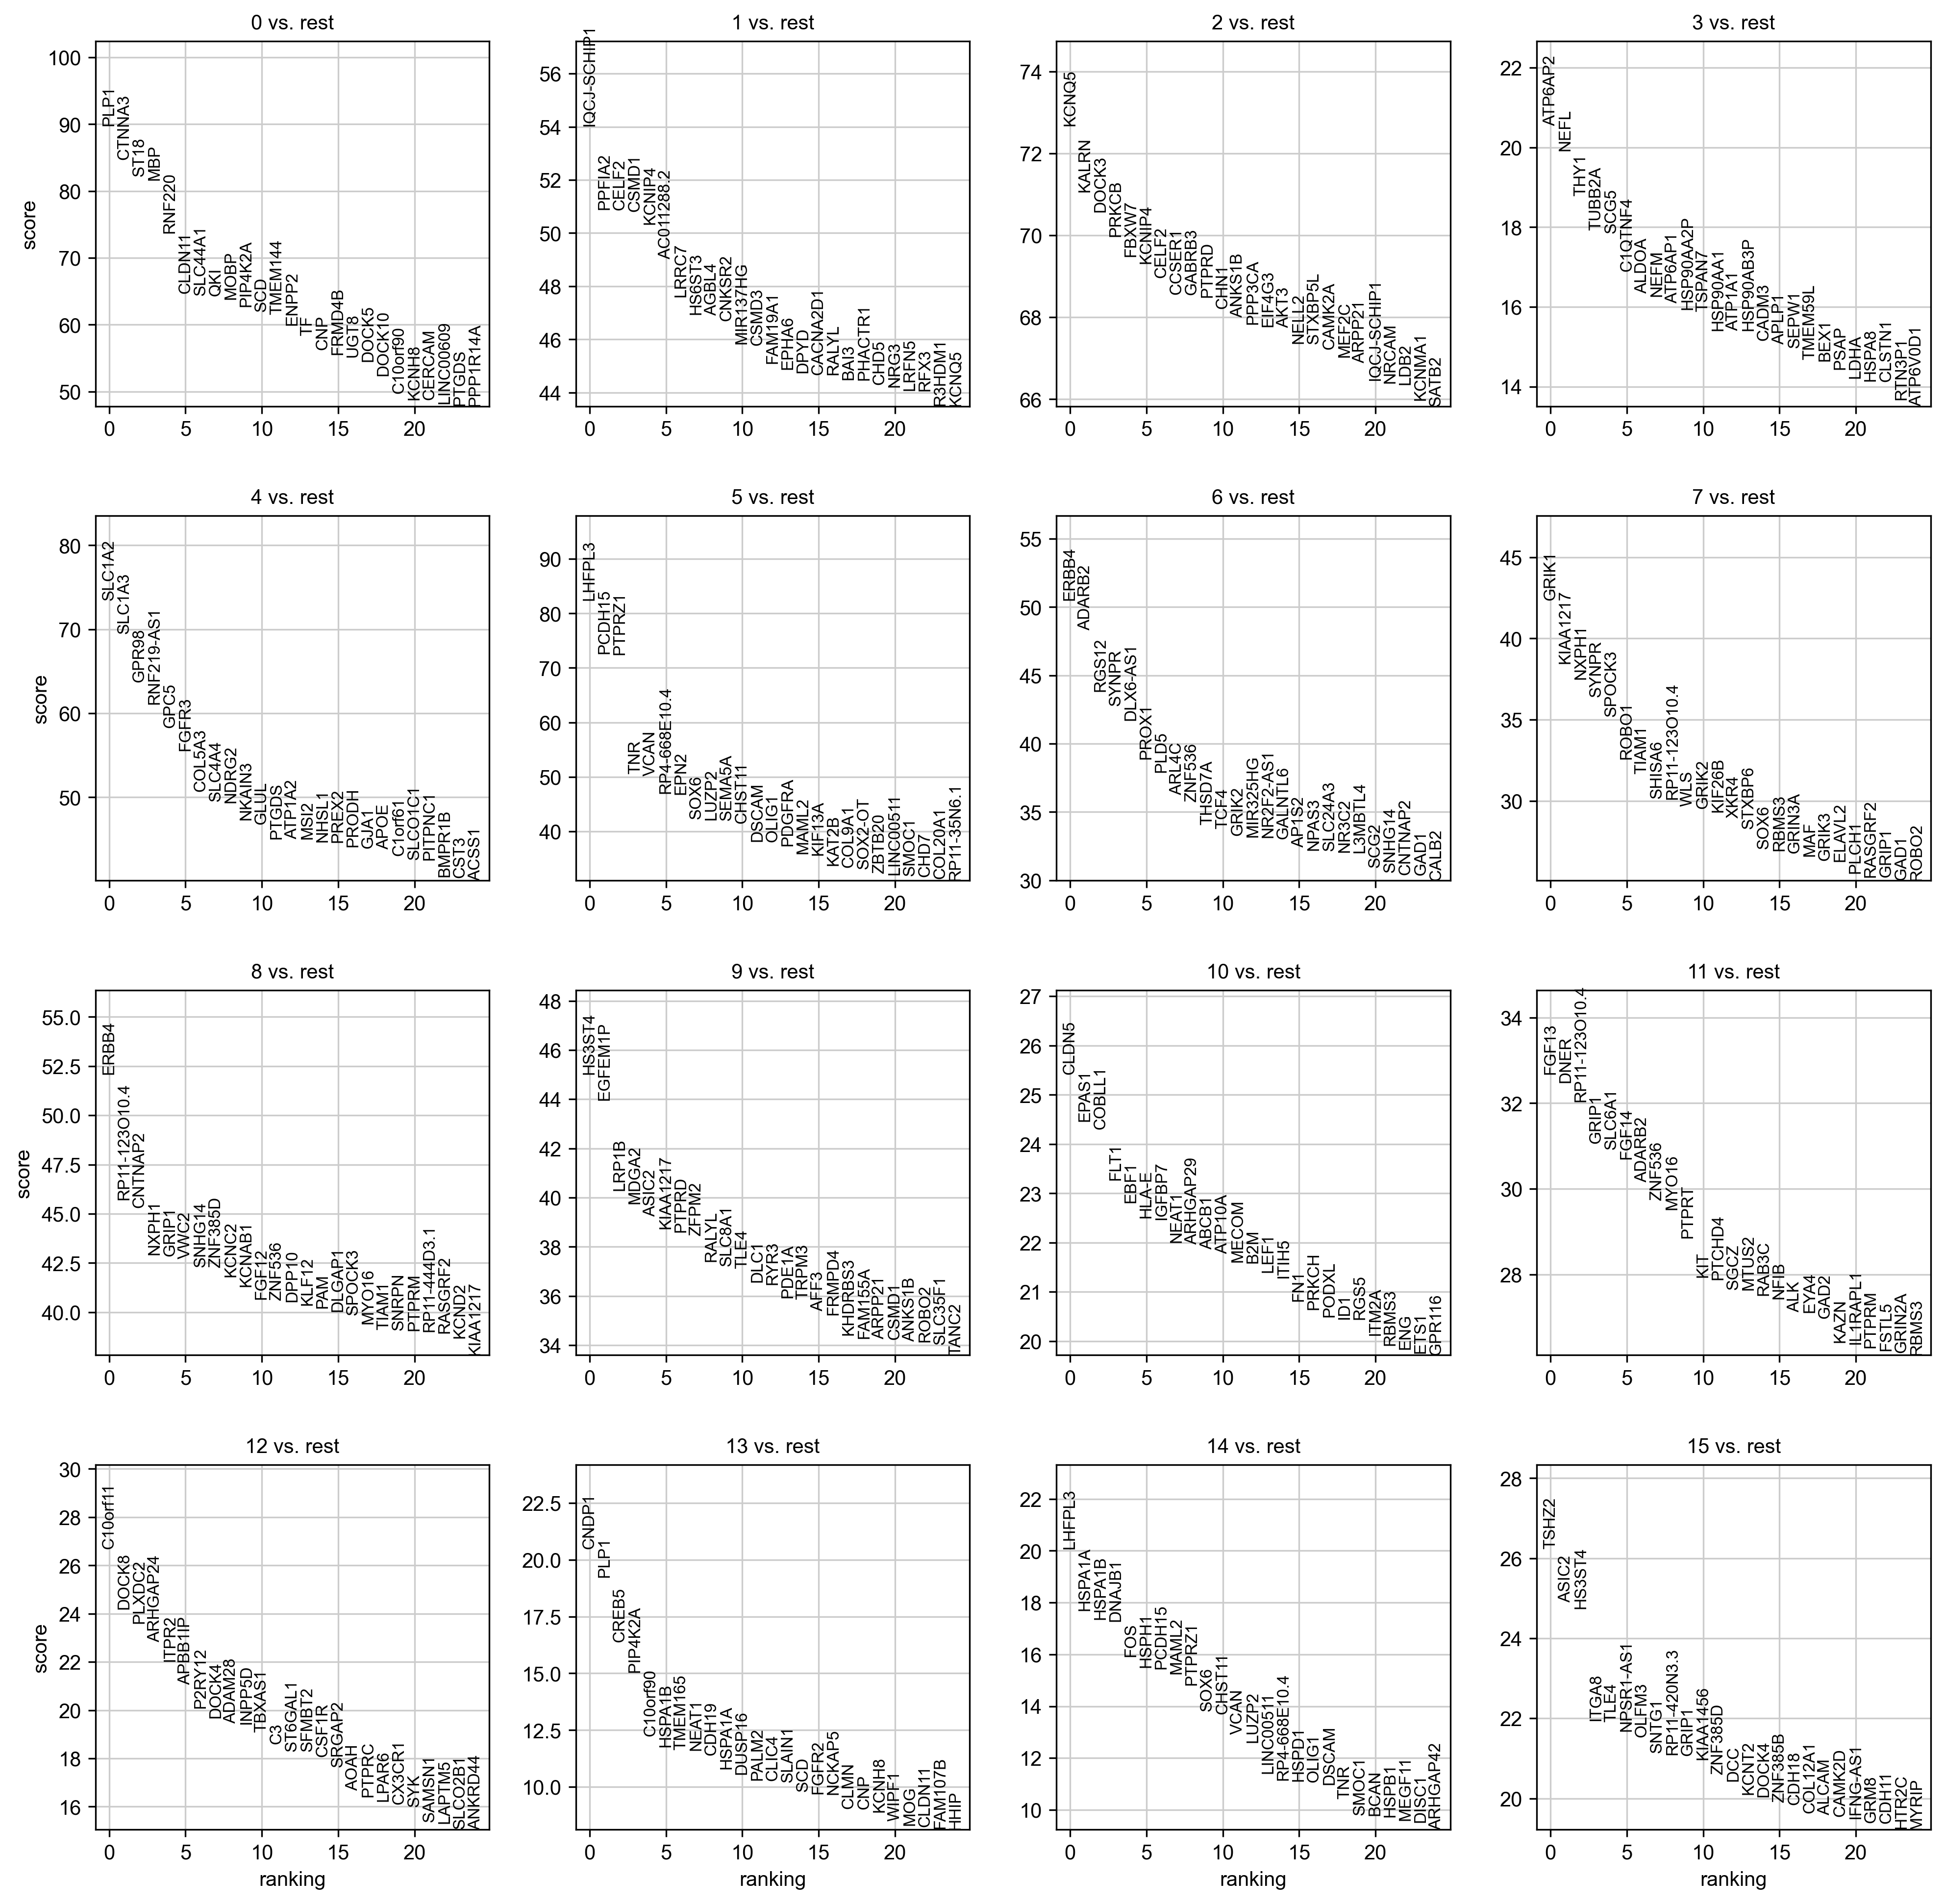

In [31]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )

In [31]:
## Docker regulatory inference
#docker run -it -v /Users/jakobmaeots/Internship/Data:/data \
#aertslab/pyscenic:0.11.0 \
#pyscenic grn \
#--num_workers 20 \ 
#--output /data/Velmeshev/ASD/asdacc_adj.tsv \
#--method grnboost2 \
#/data/Velmeshev/ASD/ASDACC.loom \
#/data/Dependencies/allTFs_hg38.txt

#docker run -it --rm \
    #-v /Users/jakobmaeots/Internship/Data:/data \
   # aertslab/pyscenic:0.12.0 \
    #pyscenic ctx \
    #/data/Velmeshev/ASD/asdacc_adj.tsv \
    #/data/Dependencies/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
    #--annotations_fname /data/Dependencies/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
    #--expression_mtx_fname /data/Velmeshev/ASD/ASDACC.loom \
    #--mode "dask_multiprocessing" \
    #--output /data/Velmeshev/ASD/asdacc_reg.csv \
    #--num_workers 20 \
    #--mask_dropouts

#docker run -it --rm \
   # -v /Users/jakobmaeots/Internship/Data:/data \
    #aertslab/pyscenic:0.12.0 \
    #pyscenic aucell \
    #/data/Velmeshev/ACC.loom\
    #/data/Velmeshev/ACC_reg.csv\
    #--output /data/Velmeshev/ACC_SCENIC.loom\
    #--num_workers 1

In [32]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [33]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

In [34]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

In [35]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

In [36]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

In [37]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(str) ))
    },
    {
        "name": "Cluster",
        "values": list(set(adata.obs['cluster'].values))
    },
    {
        "name": "Sex",
        "values": list(set(adata.obs['sex'].values))
    },
    {
        "name": "Sample",
        "values": list(set(adata.obs['sample'].values))
    }
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

In [38]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [39]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    "Cluster": np.array(adata.obs['cluster'].values),
    "Sex": np.array(adata.obs['sex'].values),
    "Sample": np.array(adata.obs['sample'].values),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [40]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file

In [ ]:
# Create a new column with the 'cell_' prefix
adata.obs['cell_id'] = 'cell_' + adata.obs['obs_names'].astype(str)

# Select the columns to save
data_to_save = adata.obs[['cell_id', 'cluster']]

# Save as a .csv file
csv_file_path = '/Data/Velmeshev/Data/ASD/ASD_cell_cluster_identifiers.csv'
data_to_save.to_csv(csv_file_path, index=False)

In [ ]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [ ]:
# Create a DataFrame from the regulons data
regulons_df = pd.DataFrame(lf.ra.Regulons, index=lf.ra.Gene)

# Create a dictionary of regulons
regulons = {}
for index, row in regulons_df.iterrows():
    # Assuming the regulon data is binary (1 or 0)
    regulons[index] = list(row[row == 1].index.values)

# Now `regulons` is a dictionary where keys are gene names and values are lists of regulons

In [ ]:
print(lf.ca.keys())

In [ ]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.Clusterings, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.ClusterID, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Louvain_clusters_Scanpy, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Cluster, index=lf.ca.CellID,
        pd.DataFrame( lf.ca.Sex, index=lf.ca.CellID,
        pd.DataFrame(lf.ca.Sample, index=lf.ca.CellID,
        pd.DataFrame( lf.ca.Percent_mito, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'Clusterings',
 'ClusterID',
 'Louvain_clusters_Scanpy',
 'Cluster',
 'Sex',
 'Sample',
 'Percent_mito',
 'nGene',
 'nUMI']

In [ ]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [ ]:
lf.close()

In [ ]:
# helper functions (not yet integrated into pySCENIC):

from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display

BASE_URL = "https://motifcollections.aertslab.org/v10nr_clust/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [ ]:
df_motifs = load_motifs('Data/Velmeshev/Data/ASD/asdacc_reg.csv')

In [ ]:
print(df_motifs.head())

In [ ]:
selected_motifs = ['BCL11A','CUX1', 'AHDC1']
df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [ ]:
#display_logos(df_motifs.head())
display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

In [ ]:
adata = sc.read( f_final_loom, validate=False)

sc.set_figure_params(frameon=False, dpi=600, fontsize=10, dpi_save=600)

sc.pl.scatter( adata, basis='highly_variable_genes_UMAP', 
    color=['Louvain_clusters_Scanpy','Clusterings'],
    title=['HVG - UMAP (Louvain clusters)','HVG - UMAP (Cell type)'],
    alpha=0.8,
    save='Velmeshev/Results/ASD/asdacc_Louvain-celltype.pdf'
    )

sc.pl.scatter( adata, basis='SCENIC_AUC_UMAP', 
    color=['Louvain_clusters_Scanpy','Clusterings'],
    title=['SCENIC - UMAP (Louvain clusters)','SCENIC - UMAP (Cell type)'], 
    alpha=0.8,
    save='Velmeshev/Results/ASD/asdacc_Louvain-celltype.pdf'
    )

In [ ]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [ ]:
plt.rcParams.update({'font.size': 12})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=150)

# Plot using drplot without specifying 's'
drplot(dr[0], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax1, palette='bright', title='Highly variable genes - UMAP')
drplot(dr[4], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax2, palette='bright', title='SCENIC AUC - UMAP')

# Adjust dot size using Matplotlib's scatter method
for ax in [ax1, ax2]:
    for collection in ax.collections:
        collection.set_sizes([20])  # Set the size of the dots; adjust the value as needed

ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="Louvain\nclusters")

plt.tight_layout()
plt.savefig("Results/Velmeshev/ASD/asdacc_dimred_umap-hvg-scenic-louvain.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
from pyscenic.binarization import binarize

In [ ]:
from math import sqrt
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon

def regulon_specificity_scores(auc_mtx, cell_type_series):
    """
    Calculates the Regulon Specificity Scores (RSS).

    :param auc_mtx: DataFrame with AUC values for all cells and regulons (n_cells x n_regulons).
    :param cell_type_series: Pandas Series with cell identifiers as index and cell type labels as values.
    :return: DataFrame with RSS values (cell type x regulon).
    """
    # Get unique cell types
    cell_types = list(cell_type_series.unique())
    n_types = len(cell_types)

    # Get regulons from the AUC matrix
    regulons = list(auc_mtx.columns)
    n_regulons = len(regulons)

    # Initialize the RSS values array
    rss_values = np.empty(shape=(n_types, n_regulons), dtype=float)

    def rss(aucs, labels):
        # Calculate RSS using Jensen-Shannon divergence
        return 1.0 - jensenshannon(aucs / aucs.sum(), labels / labels.sum())

    # Calculate RSS for each regulon and cell type
    for cidx, regulon_name in enumerate(regulons):
        for ridx, cell_type in enumerate(cell_types):
            aucs = auc_mtx[regulon_name].values
            labels = (cell_type_series == cell_type).astype(int)
            rss_values[ridx, cidx] = rss(aucs, labels)

    # Return the RSS values as a DataFrame
    return pd.DataFrame(data=rss_values, index=cell_types, columns=regulons)

In [ ]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['Clusterings'] )
rss_cellType

In [ ]:
from adjustText import adjust_text

# Define the categories
cats = sorted(list(set(cellAnnot['Clusterings'])))

# Create the figure with a layout that fits 11 panels
fig = plt.figure(figsize=(18, 12))  # Adjust the figure size as needed

# Determine the number of rows and columns needed
n_panels = len(cats)
ncols = 4  # You can adjust this based on your preference
nrows = (n_panels + ncols - 1) // ncols  # Ceiling division to ensure enough rows

# Iterate over categories and create subplots
for c, num in zip(cats, range(1, n_panels + 1)):
    x = rss_cellType.T[c]
    ax = fig.add_subplot(nrows, ncols, num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim(x.min() - (x.max() - x.min()) * 0.05, x.max() + (x.max() - x.min()) * 0.05)

    # Set font size for texts
    for t in ax.texts:
        t.set_fontsize(12)

    # Remove axis labels
    ax.set_ylabel('')
    ax.set_xlabel('')

    # Adjust text to prevent overlap
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom',
                arrowprops=dict(arrowstyle='-', color='lightgrey'), precision=0.001)

# Set figure-wide labels
fig.text(0.5, 0.02, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.02, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center',
         rotation='vertical', size='x-large')

# Adjust layout and save the figure
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
    'figure.titlesize': 'large',
    'axes.labelsize': 'medium',
    'axes.titlesize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium'
})
plt.savefig("Velmeshev/Results/ASD/asdacc_cellType-RSS-top5.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [ ]:
# Compute the z-scores for each column
z_scores = {col: (auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0) for col in auc_mtx.columns}

# Convert the dictionary of z-scores to a DataFrame
auc_mtx_Z = pd.DataFrame(z_scores, index=auc_mtx.index)

# Optionally, sort the index if needed
# auc_mtx_Z.sort_index(inplace=True)

# Now auc_mtx_Z contains the z-scores for each column

In [ ]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [ ]:
colors = sns.color_palette('tab20',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['Clusterings'] ]

In [ ]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("Results/Velmeshev/ASD/asdacc_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

In [ ]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("Results/Velmeshev/ASD/asdacc_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

In [ ]:
# Select the top regulons
top10reg = auc_mtx_Z.columns[:10]  # Adjust this to select your top regulons

# Aggregate data by cluster
cluster_auc_mtx = auc_mtx_Z[top10reg].groupby(cellAnnot['Clusterings']).mean()

# Plot the heatmap
sns.set(font_scale=1.2)
g = sns.clustermap(cluster_auc_mtx, annot=False, square=False, linecolor='gray',
                   yticklabels=True, xticklabels=True, vmin=-2, vmax=6,
                   cmap="YlGnBu", figsize=(12, 8))

g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('Clusters')
g.ax_heatmap.set_xlabel('Regulons')

# Save the figure
plt.savefig("Results/Velmeshev/ASD/asdacc_cluster-heatmap-top5.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
print("Available regulons in auc_mtx_Z:", auc_mtx_Z.columns.tolist())

In [ ]:
# Load the CSV file containing regulon information
df_regulons = pd.read_csv(df_motifs, header=[0, 1], index_col=[0, 1])

# Ensure the index is a MultiIndex
if not isinstance(df_regulons.index, pd.MultiIndex):
    df_regulons.set_index(['TF', 'MotifID'], inplace=True)

# Filter the DataFrame to find rows where the TF is 'ETV5'
TFAP4_regulon = df_regulons.xs('TFAP4', level='TF')

# Extract target genes from the 'TargetGenes' column
TFAP4_target_genes = []
for entry in etv5_regulon[('Enrichment', 'TargetGenes')]:
    # Extract gene names from the list of tuples
    genes = [gene for gene, _ in eval(entry)]  # Use eval to convert string representation of list to actual list
    TFAP4_target_genes.extend(genes)

# Remove duplicates by converting to a set, then back to a list for the final output
TFAP4_target_genes = list(set(TFAP4_target_genes))

# Display the extracted target genes
print("TFAP4 Target Genes:", TFAP4_target_genes)

In [ ]:
# Save AUC/RSS scores
rss_cellType.to_csv("Data/Velmeshev/ASD/asdacc_all_regulons_auc.tsv", sep="\t")

# Calculate rank per column (cluster) — highest value gets rank 1
regulon_ranks = rss_cellType.rank(axis=0, ascending=False, method='min')

In [ ]:
# Load the file
df_auc = pd.read_csv("Data/Velmeshev/ASD/asdacc_all_regulons_auc.tsv", sep='\t', index_col=0)

# Rank each row (cluster) across regulons: higher AUC → rank 1
df_ranks = df_auc.rank(axis=1, ascending=False, method='min')

# Save both AUC and rank DataFrames if desired
df_auc.to_csv("Data/Velmeshev/ASD/asdacc_regulon_auc_values.tsv", sep='\t')
df_ranks.to_csv("Data/Velmeshev/ASD/asdacc_regulon_auc_ranks.tsv", sep='\t')

In [ ]:
cluster_id = 1  # Make sure this matches the index exactly, could be '1', 'Cluster 1', etc.
top5 = df_auc.loc[cluster_id].sort_values(ascending=False).head(5)
print(top5)

In [ ]:
# Step 1: Load the AUC matrix (clusters as rows, regulons as columns)
df_auc = pd.read_csv("Data/Velmeshev/ASD/asdacc_all_regulons_auc.tsv", sep="\t", index_col=0)

# Step 2: Transpose so that clusters become columns and regulons become rows
df_auc = df_auc.T
df_auc.index.name = "regulon"

# Step 3: Melt to tidy format (one row per regulon-cluster pair)
df_long = df_auc.reset_index().melt(id_vars="regulon", var_name="cluster", value_name="AUC")

# Step 4: Rank regulons within each cluster by AUC (1 = highest)
df_long['Rank'] = df_long.groupby('cluster')['AUC'].rank(ascending=False, method='min').astype(int)

# Step 5: Clean regulon names (strip '(+)', etc.) and standardize casing
df_long['gene'] = df_long['regulon'].astype(str).str.replace(r'[\(\)_+]', '', regex=True).str.upper().str.strip()

# Step 6: Load RBP gene lists
rbp_sets = []

# RBPDB
rbpdb = pd.read_excel("Data/RBP_Lists/RBPDB.xlsx")
rbp_sets.append(set(rbpdb['Gene Name'].astype(str).str.upper().str.strip()))

# EMBL
embl = pd.read_excel("Data/RBP_Lists/EMBL_RBP.xlsx")
rbp_sets.append(set(embl['UNIQUE'].astype(str).str.upper().str.strip()))

# EURBP
eurbp = pd.read_csv("Data/RBP_Lists/EURBP.txt", sep="\t", header=None)
rbp_sets.append(set(eurbp[1].astype(str).str.upper().str.strip()))

# Step 7: Create a union of all RBP names
rbp_all = set.union(*rbp_sets)

# Step 8: Filter for regulons matching known RBPs
df_filtered = df_long[df_long['gene'].isin(rbp_all)]

# Step 9: Save output
df_filtered.to_csv("Data/Velmeshev/ASD/asdacc_rbp_regulons_auc_rank.tsv", sep="\t", index=False)

In [ ]:
# Start from df_filtered created earlier

# Pivot to wide format for AUC values
auc_wide = df_filtered.pivot(index='regulon', columns='cluster', values='AUC')
auc_wide.columns = [f"AUC_cluster_{col}" for col in auc_wide.columns]

# Pivot to wide format for ranks
rank_wide = df_filtered.pivot(index='regulon', columns='cluster', values='Rank')
rank_wide.columns = [f"Rank_cluster_{col}" for col in rank_wide.columns]

# Merge AUC and Rank side by side
final_df = pd.concat([auc_wide, rank_wide], axis=1)

# Reset index to make 'regulon' a column
final_df.reset_index(inplace=True)

# Save to TSV
final_df.to_csv("Data/Velmeshev/ASD/asdacc_rbp_regulons_auc_rank_wide.tsv", sep="\t", index=False)

In [ ]:
# Load the file
df = pd.read_csv("Data/Velmeshev/ASD/asdacc_rbp_regulons_auc_rank_wide.tsv", sep="\t")

# Extract just the AUC columns
auc_cols = [col for col in df.columns if col.startswith("AUC_cluster_")]
auc_data = df.set_index("regulon")[auc_cols]

# Optional: normalize rows for better visualization
# auc_data = auc_data.div(auc_data.max(axis=1), axis=0)

# Create the heatmap
plt.figure(figsize=(12, max(6, 0.2 * len(auc_data))))  # Adjust height based on number of regulons
sns.heatmap(auc_data, cmap="viridis", linewidths=0.5, linecolor='gray')

# Set labels and title
plt.xlabel("Cluster")
plt.ylabel("RBP Regulon")
plt.title("RBP Regulon AUC per Cluster Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Load the wide-format RBP regulon file
df_wide = pd.read_csv("Data/Velmeshev/ASD/asdacc_rbp_regulons_auc_rank_wide.tsv", sep="\t")

# Clean up regulon names to extract gene symbols (e.g., "TFAP4(+)" -> "TFAP4")
df_wide["TF"] = df_wide["regulon"].astype(str).str.replace(r"\(\+\)", "", regex=True).str.upper()

# Step 2: Load the regulon structure file
df_regulons = pd.read_csv("Data/Velmeshev/ASD/asdacc_Data/Velmeshev/ASD/1ASDreg.csv", header=[0, 1], index_col=[0, 1])

# Step 3: Extract target genes for each regulon
results = []

for tf in df_wide["TF"].unique():
    try:
        tf_regulon = df_regulons.xs(tf, level="TF")
        tf_targets = []
        for entry in tf_regulon[("Enrichment", "TargetGenes")]:
            tf_targets.extend([gene for gene, _ in eval(entry)])  # Use eval to parse stored list of tuples
        tf_targets = sorted(set(tf_targets))  # Remove duplicates
        results.append({"TF": tf, "TargetGenes": ", ".join(tf_targets)})
    except KeyError:
        continue  # Skip TFs not found in the regulon structure file

# Step 4: Create final DataFrame and merge with wide info (optional)
df_targets = pd.DataFrame(results)
df_final = pd.merge(df_wide, df_targets, on="TF", how="left")

# Step 5: Save
df_final.to_csv("Data/Velmeshev/ASD/asdacc_rbp_regulons_with_targets.tsv", sep="\t", index=False)